# Web Scraping Indeed.com and Predicting Energy Modeling Careers 

## Summary

Looking at the job market for energy modelers.

### Questions:
***THE OVER-ARCHING CURIOUSITY*** : What can the job market tells us about energy modeling careers?
In each step of the workflow, additional questions are raised based on the availability and the nature of the data. Here are a few previews:
* What are most popular softwares that employers look for in a candidate? 
* What are the most sought-out credentials?
* What are the educational background that the employers typically ask for? 
* Is there diversity in the job pool? 

### Methods: 
#### Step 1: Data Collection
When working on this project, I googled and learned from a lot of projects to achieve the goal of analyzing the job market for energy modelers. 

I mainly based my code from Sam Billmore:
https://github.com/SamBillmore/JobSiteWebscrapingSalaryPrediction/blob/master/Indeed_webscraping_and_salary_prediction.ipynb 
This is often referred to as 'Base Codes' in the comments below.

Scraping indeed with BeautifulSoup is a popular method that many people on the internet have done before. At this time, the indeed API is still limited. The reason why indeed.com was picked because it holds a simple text page where relevant entries can be found easily. 

Overall, the following assumptions are used to determine the data collected: 
* Data on job titles, location, companies, post date, and job description were scraped from indeed.com. 
* The search criteria is limited to "energy+modeling" results to limit the search output size. 
* I made adjustments to the base code along the way because his method of data collection does not apply well to energy modeling job markets since it filters out the postings without a salary value. 

#### Data Limitations
* This is one-point-in-time scrap that does not entails the trends over time. 
* The use of language may be a considerable limitation. For instance, 'energy modeling' is widely used in the industry while 'energy modelling' is the grammarically corect spelling. 
* Indeed does have Salary data, but they are not all available or complete. 
* Indeed does have Company data, but this information is not collected at this time.

#### Step 2: Data Exploration
The goal of data exploration is to briefly look and access the data collection. We aim not to go in depth, but as fast and cursory enough to have an idea of what the data can tell us, what we need to improve upon, and where the limitations lie. 

The data exploration process utilizes data reduction methods and various kinds of graphs to see what the collected data contains and whether there are any issue (such as further cleaning or missing values) that can warrant warnings in the analysis. For the most part, I sought out the frequencies of key terms and graph the frequencies for Job Title and Job Description. 

***Things that still need to be further work:***
* Cleaning Locations data
* Identifying Outliers 
* Potentially adding more Company information such as Reviews, Sizes (like number of people, etc.), Industry Activities, Type, and more.
* Categorization of the Job Title to be senior/middle/or entry-level 

***Interesting questions that may derive from the data (that I have not yet explore):***
* Are larger companies hire more senior vs entry-level professionals? 
* what are the distribution of seniority in the energy modeling world? 

From this process, I tokenized the Job Description to be ready for NLTK analysis. 

Here are some of the ***key findings***: 
* ***Software***: 
    * eQuest is still a very popular tool. 
    * For some reason, Energy + is heavily used more so than EnergyPlus. 
    * While scripting language such as Python appeared more frequent than expected, Excel still takes the cake as the number one analysis tool outside of the building simulation software suites.
* ***Language to Candidates***: 
    * Engineers comes up more often than architect or even analyst. 
    * Experience is highly used. Without diving further, it's not indicating the extend of experience, but experience is mentioned often. 
    
***Limitations***: It's important to the possible obstacles that may be encountered in the Analysis space due to the quality and quantity constraints of the data, such as:
* Location still needs to be clean to give meaningful results.
* Similar words and wordings may not be grouped very well or may need improvement. 

#### Step 3: Data Analysis 
See Part 2.
#### Step 4: Presentation & Conclusion
See Part 2.


### Notes from Digesting Base Code (Optional - Skip to Codes)

Scraping indeed.com using BeautifulSoup. The reason why indeed.com was picked because it holds a simple text page where relevant entries can be found easily. 

#### Functions:
* extract_job_title_mt(result)
* extract_company_mt(result)
* extract_location_mt(result)
* extract_salary_mt(result)
* jobs_df_from_html(dict_html)
* request_html(url_template,term,sal_rng,return_dict)
* request_concurrent(sal_rng_list,search_terms)

#### Steps:
1) Define: search_terms, sal_rng_list
2) dict_hmtl = request_concurrent(sal_range, search_terms)

#### Observations:
* Search queries affect results. If include salary range, the results is different compare to no salary range.
* Search is limited to the first , assuming latest 1000 posts. 
* Get the job description: page_soup.find('div', attrs={'class':'jobsearch-SerpJobCard unifiedRow row result'})['data-jk'] 

#### Libraries:
* ***multiprocessing*** = allows to use multiple proccesses, launch multiple python processes (may not talk to each other or not) --> shorten the time that a python process takes 
    * ***Manager object*** = share data between the processes by creating a manager object. Each manager has a list / dictionary. Function to append the manager list and holds the values between all the processes. 
* ***tqdm*** = a smart progress meter
    * ***tdq_notebook*** = Jupyter Notebook widget using tqdm 
    * for x in tdq_notebook(range) => get the progress bar of the loop
* ***threading*** = perform multiple tasks at one time, but troubles rise when there are shared variables 
    * When you create a *Thread*, you pass it a function and a list containing the arguments to that function.
* ***string.format*** = format the string with (insert1, insert2, and insert3)
    * url_template = https://www.indeed.com/jobs?as_and={}&salary={}&start={}
    * term = 'data'
    * sal_rng = '$60K-$90K'
    * input == pg_url = url_template.format(term,sal_rng,0) 
    * output == 'https://www.indeed.com/jobs?as_and=data&salary=$60K-$90K&start=0'



In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import multiprocessing as mp
import threading
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
#import scikitplot as skplt

In [2]:
%matplotlib inline

In [3]:
#largely from Base Codes
def extract_job_title_mt(result):
    """
    Extracts the job title for a job on Indeed's website
    """
    try:
        job_title = result.find('a', attrs={'class':'turnstileLink'}).text
    except:
        job_title = np.nan
    return job_title

def extract_company_mt(result):
    """
    Extracts the company for a job on Indeed's website
    """
    try:
        company = result.find('span', attrs={'class':'company'}).text
    except:
        company = np.nan
    return company

def extract_location_mt(result):
    """
    Extracts the location for a job on Indeed's website
    """
    try:
        location = result.find('span', attrs={'class':'location'}).text
    except:
        try:
            location = result.find('div', attrs={'class':'location'}).text
        except:
            location = np.nan
    return location


# alternative way to retrieve description - WIP 

#def getdes(pg_url):
#     # Find max number of pages
#     req = requests.get(pg_url)
#     pg_soup = BeautifulSoup(req.text, 'html.parser')
#     description = pg_soup.find('div', attrs={'id':'jobDescriptionText'}).text 
#     description = description.replace('\n','')
#     return description

# def extract_description(result):
#     """
#     Extracts the Description for a job on Indeed's website
#     """
#     try:
#         link = result.find('a', attrs={'class':'turnstileLink'})['id']
#         base_url = 'https://www.indeed.com/viewjob?jk='
#         total_url = base_url + link[3:len(link)]
#         description = getdes(link)       
#     except:
#         description = np.nan
#     return description

# Added to basecode to get the JobID that would lead to description
def extract_description(result):
    """
    Extracts the Description for a job on Indeed's website
    """
    try:
        description = result.find('a', attrs={'class':'turnstileLink'})['id']       
    except:
        description = np.nan
    return description

def extract_date(result):
    """
    Extract date
    """
    try: 
        date_post = result.find('span', attrs={'class':'date'}).text
    except:
        date_post = np.nan
    return date_post

def request_html(url_template,term,sal_rng,return_dict):
    """
    Obtains html from indeed.com for a specific city
    """
    # Find max number of pages
    pg_url = url_template.format(term,sal_rng,0)
    req = requests.get(pg_url)
    soup = BeautifulSoup(req.text, 'html.parser')
    job_count = str(soup.find('div', attrs = {'id':'searchCount'}))
    job_count = int(job_count.split(' ')[-2].replace(',',''))
    if job_count > 1500:
        job_count = 1500
    max_sal_rng_results = int(np.ceil(job_count/1.5))
    
    for start in tqdm_notebook(range(0, max_sal_rng_results, 10)):
        url = url_template.format(term,sal_rng,start)
        try:
            r = requests.get(url)
        except requests.RequestException:
            return None
        if r.status_code != 404:
            key = sal_rng+'_'+str(start)
            return_dict[key] = r.text

def request_concurrent(sal_rng_list,search_terms):
    """
    Multithreading for requesting html from indeed.com
    
    html obtained using function request_html
    
    Threaded by city
    """
    manager = mp.Manager()
    return_dict = manager.dict()
    threads = []
    
    url_template = "https://www.indeed.com/jobs?as_and={}&salary={}&start={}"
    
    for term in tqdm_notebook(search_terms):
        for sal_rng in tqdm_notebook(sal_rng_list):
            thread = threading.Thread(name=term+'_'+sal_rng, target=request_html,
                                      args=(url_template,term,sal_rng,return_dict))
            thread.start()
            threads.append(thread)
    
    for t in threads:
        t.join()
    
    return return_dict

In [4]:
#leave salary range empty
sal_rng_list = ['']
search_terms = ['energy+modeling']

dict_html = request_concurrent(sal_rng_list,search_terms)

In [5]:
# All from Base Codes with little modification
def jobs_df_from_html(dict_html):
    """
    Creates a dataframe from the html for each job on the indeed website
    
    Dataframe includes:
    - Job title
    - Company
    - Location
    - Salary
    """
    job_title = []
    company = []
    location = []
    description = []
    date_post =[]
    for value in dict_html.values():
        soup = BeautifulSoup(value, 'html.parser')
        for job in soup.find_all('div', attrs={'class': re.compile('jobsearch-SerpJobCard.*')}):
            job_title.append(extract_job_title_mt(job))
            company.append(extract_company_mt(job))
            location.append(extract_location_mt(job))
            description.append(extract_description(job))
            date_post.append(extract_date(job))

    jobs = pd.DataFrame({'Job_title': job_title,
                           'Company': company,
                         'Location': location,
                        'Raw JobID': description,
                        'Date Posted': date_post})
    return jobs

In [6]:
mt_scraped_jobs = jobs_df_from_html(dict_html)

In [7]:
mt_scraped_jobs.shape

(3000, 5)

In [8]:
mt_scraped_jobs.head()

,Job_title,Company,Location,Raw JobID,Date Posted
0,"\n Associate, Energy & Climate Prac...",\n\n 3Degrees,"San Francisco, CA",jl_7ec62b1fa6e18577,2 hours ago
1,NaN,NaN,NaN,NaN,2 hours ago
2,NaN,NaN,NaN,NaN,2 hours ago
3,\n Recent Graduate: Clean Energy An...,\n\n Southern California Edison,"Rosemead, CA 91771",jl_857108d858e6339d,26 days ago
4,NaN,NaN,NaN,NaN,26 days ago


In [9]:
# All from Base Codes with little modification
def clean_jobs(jobs_df):
    """
    Cleans a pandas dataframe received from scraping the indeed.com
    """
    # Remove blank salaries
    an_sal_jobs = jobs_df.dropna().copy()
    
    # Remove duplicates
    an_sal_jobs.drop_duplicates(subset=["Job_title", "Company"], keep=False, inplace=True)
    
    # Remove carriage returns
    for i in an_sal_jobs.columns:
        an_sal_jobs[i] = an_sal_jobs[i].map(lambda x: x.replace('\n',''))
    output = an_sal_jobs
    return output


In [10]:
an_sal_jobs = clean_jobs(mt_scraped_jobs)
an_sal_jobs.shape

(603, 5)

In [11]:
an_sal_jobs.head()

,Job_title,Company,Location,Raw JobID,Date Posted
0,"Associate, Energy & Climate Practice",3Degrees,"San Francisco, CA",jl_7ec62b1fa6e18577,2 hours ago
3,Recent Graduate: Clean Energy Analyst,Southern California Edison,"Rosemead, CA 91771",jl_857108d858e6339d,26 days ago
6,Energy Modeling Engineer,US-EcoLogic,"Irving, TX",jl_b61acdd3af88f3f9,3 days ago
12,"Valuation & Modeling Consultant,",Deloitte,"San Francisco, CA",jl_afcd7eefa31c59f7,25 days ago
15,Energy Auditor,Lime Energy,"Newark, NJ 07102 (Central Business District area)",jl_325e571e6bd83a42,30+ days ago


In [46]:
#Getting the Job Description 
base_url = 'https://www.indeed.com/viewjob?jk='
an_sal_jobs['JobID'] = an_sal_jobs['Raw JobID'].apply(lambda x: x[3:len(x)])
an_sal_jobs['Link'] = base_url + an_sal_jobs['JobID']

In [47]:
an_sal_jobs.head()

,Job_title,Company,Location,Raw JobID,Date Posted,JobID,Link
0,"Associate, Energy & Climate Practice",3Degrees,"San Francisco, CA",jl_7ec62b1fa6e18577,2 hours ago,7ec62b1fa6e18577,https://www.indeed.com/viewjob?jk=7ec62b1fa6e1...
3,Recent Graduate: Clean Energy Analyst,Southern California Edison,"Rosemead, CA 91771",jl_857108d858e6339d,26 days ago,857108d858e6339d,https://www.indeed.com/viewjob?jk=857108d858e6...
6,Energy Modeling Engineer,US-EcoLogic,"Irving, TX",jl_b61acdd3af88f3f9,3 days ago,b61acdd3af88f3f9,https://www.indeed.com/viewjob?jk=b61acdd3af88...
12,"Valuation & Modeling Consultant,",Deloitte,"San Francisco, CA",jl_afcd7eefa31c59f7,25 days ago,afcd7eefa31c59f7,https://www.indeed.com/viewjob?jk=afcd7eefa31c...
15,Energy Auditor,Lime Energy,"Newark, NJ 07102 (Central Business District area)",jl_325e571e6bd83a42,30+ days ago,325e571e6bd83a42,https://www.indeed.com/viewjob?jk=325e571e6bd8...


In [48]:
def getdes(pg_url):
    # Find max number of pages
    req = requests.get(pg_url)
    pg_soup = BeautifulSoup(req.text, 'html.parser')
    
    #description = pg_soup.find('div', attrs={'id':'jobDescriptionText'}).text 
    try:
        description = pg_soup.find('div', attrs={'id':'jobDescriptionText'}).text 
        description = description.replace('\n','')
    except AttributeError:
        description = None
    
    return description

In [49]:
#Redudant step to copy the dataframe
cleanjobs = an_sal_jobs.copy()

In [50]:
cleanjobs.head()

,Job_title,Company,Location,Raw JobID,Date Posted,JobID,Link
0,"Associate, Energy & Climate Practice",3Degrees,"San Francisco, CA",jl_7ec62b1fa6e18577,2 hours ago,7ec62b1fa6e18577,https://www.indeed.com/viewjob?jk=7ec62b1fa6e1...
3,Recent Graduate: Clean Energy Analyst,Southern California Edison,"Rosemead, CA 91771",jl_857108d858e6339d,26 days ago,857108d858e6339d,https://www.indeed.com/viewjob?jk=857108d858e6...
6,Energy Modeling Engineer,US-EcoLogic,"Irving, TX",jl_b61acdd3af88f3f9,3 days ago,b61acdd3af88f3f9,https://www.indeed.com/viewjob?jk=b61acdd3af88...
12,"Valuation & Modeling Consultant,",Deloitte,"San Francisco, CA",jl_afcd7eefa31c59f7,25 days ago,afcd7eefa31c59f7,https://www.indeed.com/viewjob?jk=afcd7eefa31c...
15,Energy Auditor,Lime Energy,"Newark, NJ 07102 (Central Business District area)",jl_325e571e6bd83a42,30+ days ago,325e571e6bd83a42,https://www.indeed.com/viewjob?jk=325e571e6bd8...


In [51]:
# This takes a long time. Be prepare to give it like 2-5 minutes depend on your computer specs.
cleanjobs['Job Description'] = tqdm_notebook(cleanjobs['Link'].apply(lambda x: getdes(x)))

In [52]:
cleanjobs.shape

(603, 8)

In [53]:
#Export to csv 
cleanjobs.to_csv('energymodelingjobs_071119.csv',sep='\t',encoding='utf-8')

This is the end of the Data Collection step.

## Data Analysis: Exploratory Data Analysis
Now that we have our data. We shall perform exploratory analysis on the lovely data we just collected. In this step, we are only doing a cursory view of the data collection. We save the more complex language analysis for the later analysis using the NLTK package and other machine learning methods. 

### Data Exploratory: Job Titles
Typically, job searcher types in the job title in the key-search as it is one of the first things that a candidate recognizes and identifies themself with. Let's take a look what the data show us at first glance.

In [54]:
cleanjobs['Job_title'].value_counts()

            Data Scientist                                                 10
            Mechanical Engineer                                             5
Energy Engineer                                                             4
            Financial Analyst                                               4
            Process Engineer                                                3
            Data Analyst                                                    2
            Design Engineer                                                 2
Energy Engineer II                                                          2
            Environmental Engineering Consultant - Arlington, VA            2
            Production Engineer                                             2
            Business Analyst                                                2
            Corporate Development Associate                                 2
            Mechanical Design Engineer                          

Let's narrow down the job description that may have overlaps. 

In [55]:
career_list = ['Energy Engineer', 'Data', 'Mechanical','Architect','Analyst', 'Manager', 'Specialist', 'Engineer',
               'Consultant', 'Simulation', 'Building','Energy', 'Sustainability','Research']\

career_list = list(map(str.lower,career_list))

In [56]:
type(career_list)

list

In [57]:
#make a new column with lowercase 
cleanjobs['Job_title_temp'] = cleanjobs['Job_title'].str.lower()
 

#Count how much many job title contains the key words
from collections import Counter
Counter(cleanjobs['Job_title_temp']).most_common(10)

[('            data scientist', 11),
 ('            mechanical engineer', 5),
 ('energy engineer', 4),
 ('            financial analyst', 4),
 ('            process engineer', 3),
 ('energy auditor', 2),
 ('            data analyst', 2),
 ('            solar pv design engineer - solar group', 2),
 ('            production engineer', 2),
 ('            corporate development associate', 2)]

In [58]:
#Alternative way to count based on the selected key words
career_df = []
for word in career_list:
    count_job = cleanjobs.Job_title_temp.str.count(word).sum()
    career_df.append([word,count_job])
career_df = pd.DataFrame(career_df, columns=['KeyWords','JobCount'])

In [59]:
career_df

,KeyWords,JobCount
0,energy engineer,10
1,data,28
2,mechanical,21
3,architect,6
4,analyst,76
5,manager,21
6,specialist,25
7,engineer,199
8,consultant,19
9,simulation,14


In [60]:
career_df = career_df.sort_values(by='JobCount',ascending=False)
career_df = career_df.reset_index(drop=True)

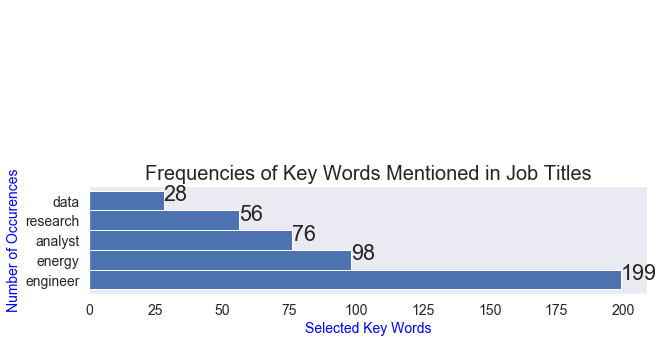

In [1392]:
ax = career_df[0:5].plot(x='KeyWords',y='JobCount',kind='barh', width=1, figsize=(10,2),legend=False,grid=False, fontsize=14)
for i,j in career_df.JobCount.items():
    ax.annotate(str(j), xy=(j, i), fontsize='large', horizontalalignment='left')
plt.title('Frequencies of Key Words Mentioned in Job Titles',fontsize=20)
plt.xlabel('Selected Key Words',fontsize=14)
plt.ylabel('Number of Occurences',fontsize=14)
plt.show()

### Data Exploratory: Job Description
The job description is a rich body of text, often consisting of several paragraphs and bullets, that describes the job duties and qualitifications. While the industry typically have similar usage of words and some terminology, the writing style and linguist often differ and may induce to a longer key-term list. 

From the job description, we can briefly see what employers look in skillsets and credentials. Things we may want to explore:
* What are the most popular software mentioned?
* What are the education requirements / preferance mentioned?
* What are the credentials mentioned? 

### Software Skillsets


In [883]:
software = ['Energy +', 'Virtual Environment', 'IES-VE', 'Trace','EnergyPlus', 'Energy Plus', 'OpenStudio', 'eQuest', 'Carrier HAP', \
            'Hourly Analysis Program', 'BeOpt', 'Design Builder', 'LadyBug','Rhino','Grasshopper','DIVA', \
           'AutoCAD','Revit', 'ArcGIS','PowerBI', 'Tableau','Python','DOE2','Sefaira','CBECC','Excel',\
           'EnergyPro', 'Energy Pro','CBECC-Res','CBECC-Com','DOE-2', 'Trane Trace', 'MFBA']
software = [x.lower() for x in software]

In [879]:
#make a new column with lowercase
cleanjobs['Jobdes_temp'] = cleanjobs['Job Description'].str.lower()
 
software_df = []
for word in software:
    count_job = cleanjobs.Jobdes_temp.str.count(word).sum()
    software_df.append([word,count_job])
software_df = pd.DataFrame(software_df, columns=['Software','FrequencyCount'])

In [880]:
cleanjobs.head()

,Job_title,Company,Location,Raw JobID,Date Posted,JobID,Link,Job Description,Job_title_temp,Jobdes_temp
0,"Associate, Energy & Climate Practice",3Degrees,"San Francisco, CA",jl_7ec62b1fa6e18577,2 hours ago,7ec62b1fa6e18577,https://www.indeed.com/viewjob?jk=7ec62b1fa6e1...,"ABOUT YOUYou are someone who loves to analyze,...","associate, energy & climate practice","about youyou are someone who loves to analyze,..."
3,Recent Graduate: Clean Energy Analyst,Southern California Edison,"Rosemead, CA 91771",jl_857108d858e6339d,26 days ago,857108d858e6339d,https://www.indeed.com/viewjob?jk=857108d858e6...,Job DescriptionENERGY FOR WHAT’S AHEADAre you ...,recent graduate: clean energy analyst,job descriptionenergy for what’s aheadare you ...
6,Energy Modeling Engineer,US-EcoLogic,"Irving, TX",jl_b61acdd3af88f3f9,3 days ago,b61acdd3af88f3f9,https://www.indeed.com/viewjob?jk=b61acdd3af88...,"Worksite Address: 911 Maryland Drive, Irving, ...",energy modeling engineer,"worksite address: 911 maryland drive, irving, ..."
12,"Valuation & Modeling Consultant,",Deloitte,"San Francisco, CA",jl_afcd7eefa31c59f7,25 days ago,afcd7eefa31c59f7,https://www.indeed.com/viewjob?jk=afcd7eefa31c...,Valuation & Modeling – Financial Modeling Cons...,"valuation & modeling consultant,",valuation & modeling – financial modeling cons...
15,Energy Auditor,Lime Energy,"Newark, NJ 07102 (Central Business District area)",jl_325e571e6bd83a42,30+ days ago,325e571e6bd83a42,https://www.indeed.com/viewjob?jk=325e571e6bd8...,Energy AuditorJob Summary:To support the rapid...,energy auditor,energy auditorjob summary:to support the rapid...


In [882]:
software_df = software_df.sort_values(by='FrequencyCount',ascending=False)
software_df= software_df.reset_index(drop=True)
software_df

,Software,FrequencyCount
0,energy +,1921.0
1,excel,657.0
2,equest,163.0
3,python,116.0
4,autocad,66.0
5,energy pro,60.0
6,revit,39.0
7,arcgis,17.0
8,tableau,16.0
9,trace,14.0


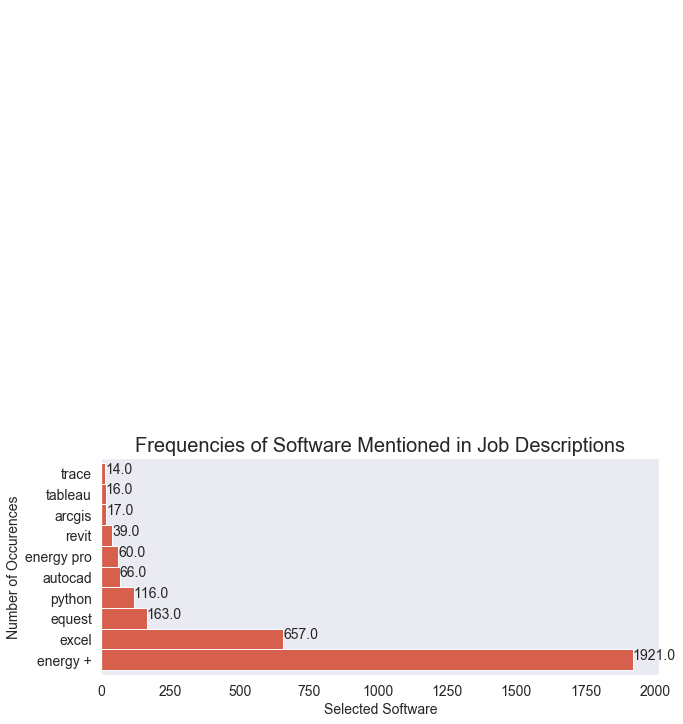

In [889]:
ax = software_df[0:10].plot(x='Software',y='FrequencyCount',kind='barh', width=1, figsize=(10,4),legend=False,grid=False, fontsize=14)
for i,j in software_df.FrequencyCount.items():
    ax.annotate(str(j), xy=(j, i), fontsize=14, horizontalalignment='left')
plt.title('Frequencies of Software Mentioned in Job Descriptions',fontsize=20)
plt.xlabel('Selected Software',fontsize=14)
plt.ylabel('Number of Occurences',fontsize=14)
plt.show()

### Education Degrees

In [67]:
degrees = ['BA or BS degree','BS degree','MS degree','Master\'s Degree','MS Preferred', 'Bachelor',
           'B.S.','B.A.','M.S.','Doctorate degree','PhD','Ph.D']
degrees = list(map(str.lower,degrees))
degrees_df = []
for word in degrees:
    count_job = cleanjobs.Jobdes_temp.str.count(word).sum()
    degrees_df.append([word,count_job])
degrees_df = pd.DataFrame(degrees_df, columns=['Degrees','FrequencyCount'])
degrees_df = degrees_df.sort_values(by='FrequencyCount',ascending=False)
degrees_df= degrees_df.reset_index(drop=True)
degrees_df

,Degrees,FrequencyCount
0,m.s.,2810.0
1,b.s.,2506.0
2,b.a.,611.0
3,bachelor,288.0
4,phd,125.0
5,ph.d,70.0
6,master's degree,41.0
7,bs degree,14.0
8,ms preferred,10.0
9,ms degree,5.0


In [755]:
degrees_dict = {'Bachelor Degree': ['BA or BS degree','BS degree', 'Bachelor','B.S.','B.A.'],
                'Master Degree': ['MS degree','Master\'s Degree','MS Preferred','M.S.'],
                'PhD Degree': ['PhD','Ph.D']}
degrees_dict_df = pd.DataFrame.from_dict(degrees_dict, orient='index')
degrees_dict_df = degrees_dict_df.unstack().dropna().sort_index(level=1)
degrees_dict_df = pd.DataFrame(degrees_dict_df).reset_index()
degrees_dict_df.columns = ['count','TypeDegree','Degrees']
del degrees_dict_df['count']
degrees_dict_df['Degrees'] = degrees_dict_df['Degrees'].str.lower()
degrees_dict_df

,TypeDegree,Degrees
0,Bachelor Degree,ba or bs degree
1,Bachelor Degree,bs degree
2,Bachelor Degree,bachelor
3,Bachelor Degree,b.s.
4,Bachelor Degree,b.a.
5,Master Degree,ms degree
6,Master Degree,master's degree
7,Master Degree,ms preferred
8,Master Degree,m.s.
9,PhD Degree,phd


In [756]:
#merge
degrees_df = pd.merge(degrees_df,degrees_dict_df,on='Degrees')
degrees_df

,Degrees,FrequencyCount,Type,TypeDegree
0,m.s.,2810.0,Master Degree,Master Degree
1,b.s.,2506.0,Bachelor Degree,Bachelor Degree
2,b.a.,611.0,Bachelor Degree,Bachelor Degree
3,bachelor,288.0,Bachelor Degree,Bachelor Degree
4,phd,125.0,PhD Degree,PhD Degree
5,ph.d,70.0,PhD Degree,PhD Degree
6,master's degree,41.0,Master Degree,Master Degree
7,bs degree,14.0,Bachelor Degree,Bachelor Degree
8,ms preferred,10.0,Master Degree,Master Degree
9,ms degree,5.0,Master Degree,Master Degree


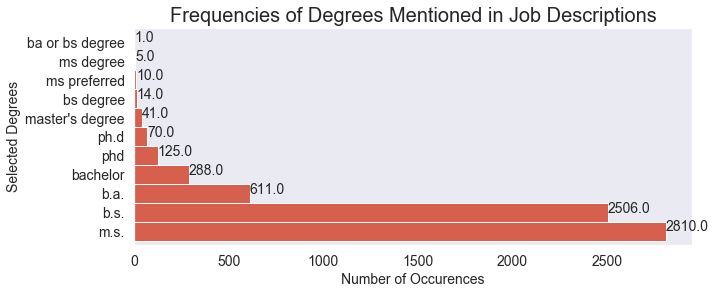

In [904]:
ax = degrees_df.plot(x='Degrees',y='FrequencyCount',kind='barh', width=1, figsize=(10,4),legend=False,grid=False, fontsize=14)
for i,j in degrees_df.FrequencyCount.items():
    ax.annotate(str(j), xy=(j,i), fontsize=14, horizontalalignment='left')
plt.title('Frequencies of Degrees Mentioned in Job Descriptions',fontsize=20)
plt.xlabel('Number of Occurences',fontsize=14)
plt.ylabel('Selected Degrees',fontsize=14)
plt.show()

In [768]:
#groupby
degrees_df_sum = degrees_df.groupby('TypeDegree').sum()


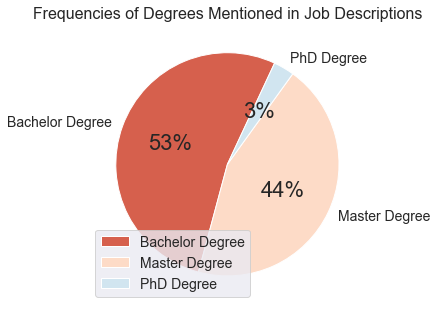

In [855]:
degrees_df_sum.plot(kind='pie', subplots=True, figsize=(5, 6), autopct='%1.0f%%', pctdistance=0.55, startangle=65, labeldistance=1.1)
plt.title('Frequencies of Degrees Mentioned in Job Descriptions',fontsize=16)
plt.legend(loc=0, prop={'size': 14})
plt.xlabel('',fontsize=14)
plt.ylabel('',fontsize=14)
plt.xticks(fontsize=12)
plt.show()

In [907]:
degrees_df_sum = degrees_df_sum.reset_index()
degrees_df_sum

,TypeDegree,FrequencyCount
0,Bachelor Degree,3420.0
1,Master Degree,2866.0
2,PhD Degree,195.0


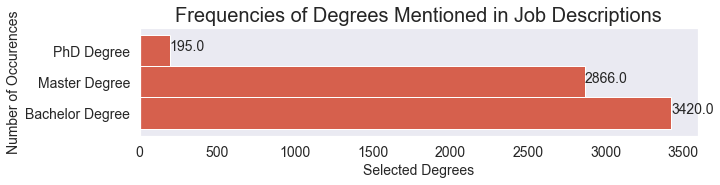

In [909]:
ax = degrees_df_sum.plot(x='TypeDegree',y='FrequencyCount',kind='barh', width=1, figsize=(10,2),legend=False,grid=False, fontsize=14)
for i,j in degrees_df_sum.FrequencyCount.items():
    ax.annotate(str(j), xy=(j,i), fontsize=14, horizontalalignment='left')
plt.title('Frequencies of Degrees Mentioned in Job Descriptions',fontsize=20)
plt.xlabel('Selected Degrees',fontsize=14)
plt.ylabel('Number of Occurences',fontsize=14)
plt.show()

### Certifications / Credentials

In [899]:
cert = ['LEED','EIT', 'E.I.T.','EMIT','C.E.M.',' CEM','CEA','BEMP', 'BEAP',' P.E.','Professional Engineer',\
        'ASHRAE','LEED AP','LEED GA', 'CPM', 'IBPSA', 'AEE', ' R.A.', 'PE License', 'CBCP' , 'BCxP','BEAP',
        'Registered Architect']
cert = [x.lower() for x in cert]
cert_df = []
for word in cert:
    count_job = cleanjobs.Jobdes_temp.str.count(word).sum()
    cert_df.append([word,count_job])
cert_df = pd.DataFrame(cert_df, columns=['Credentials','FrequencyCount'])
cert_df = cert_df.sort_values(by='FrequencyCount',ascending=False)
cert_df= cert_df.reset_index(drop=True)
cert_df

,Credentials,FrequencyCount
0,p.e.,1923.0
1,e.i.t.,937.0
2,r.a.,603.0
3,eit,59.0
4,cea,54.0
5,professional engineer,41.0
6,c.e.m.,30.0
7,leed,29.0
8,ashrae,17.0
9,cem,10.0


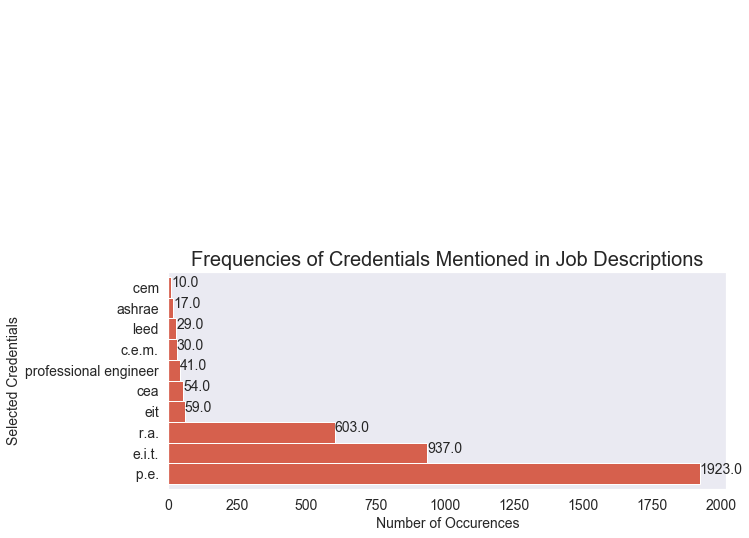

In [901]:
ax = cert_df[0:10].plot(x='Credentials',y='FrequencyCount',kind='barh', width=1, figsize=(10,4),legend=False,grid=False, fontsize=14)
for i,j in cert_df.FrequencyCount.items():
    ax.annotate(str(j), xy=(j,i), fontsize=14, horizontalalignment='left')
plt.title('Frequencies of Credentials Mentioned in Job Descriptions',fontsize=20)
plt.xlabel('Number of Occurences',fontsize=14)
plt.ylabel('Selected Credentials',fontsize=14)
plt.show()

### Word Cloud 
For exploration's sake, let see what are the popular words used the description. 

In [71]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [93]:
alldes = cleanjobs['Jobdes_temp'].tolist()

In [94]:
type(alldes)

list

In [98]:
#Tokenize the list
from nltk.tokenize import word_tokenize
token_alldez = [word_tokenize(i) for i in alldes]

In [100]:
flat_alldes = [item for sublist in token_alldez for item in sublist]

In [101]:
import string
useless_words = list(STOPWORDS) + list(string.punctuation) 

In [290]:
clean_flat = [w for w in flat_alldes if not w in useless_words and len(w) > 1]
clean_flat = [word for line in clean_flat for word in line.split('.')]
#Test
sorted(w for w in set(clean_flat) if 'senior' in w)

['mid-to-senior',
 'relayingsenior',
 'responsibilitiessenior',
 'senior',
 'senior-level',
 'summarysenior']

In [276]:
print("Before:" , len(flat_alldes))
print("After:" ,len(clean_flat))

Before: 395108
After: 233700


In [278]:
Counter(clean_flat).most_common(30)

[('energy', 2063),
 ('will', 1933),
 ('work', 1800),
 ('experience', 1746),
 ('engineering', 1356),
 ('design', 1186),
 ('team', 1182),
 ('data', 1118),
 ('development', 1034),
 ('including', 981),
 ('modeling', 952),
 ('analysis', 948),
 ('skills', 913),
 ('research', 903),
 ('technical', 882),
 ('business', 864),
 ('management', 844),
 ('project', 840),
 ('systems', 805),
 ('new', 781),
 ('position', 778),
 ('years', 748),
 ('support', 740),
 ('ability', 724),
 ('projects', 662),
 ('related', 647),
 ('degree', 618),
 ('knowledge', 595),
 ('required', 554),
 ('national', 553)]

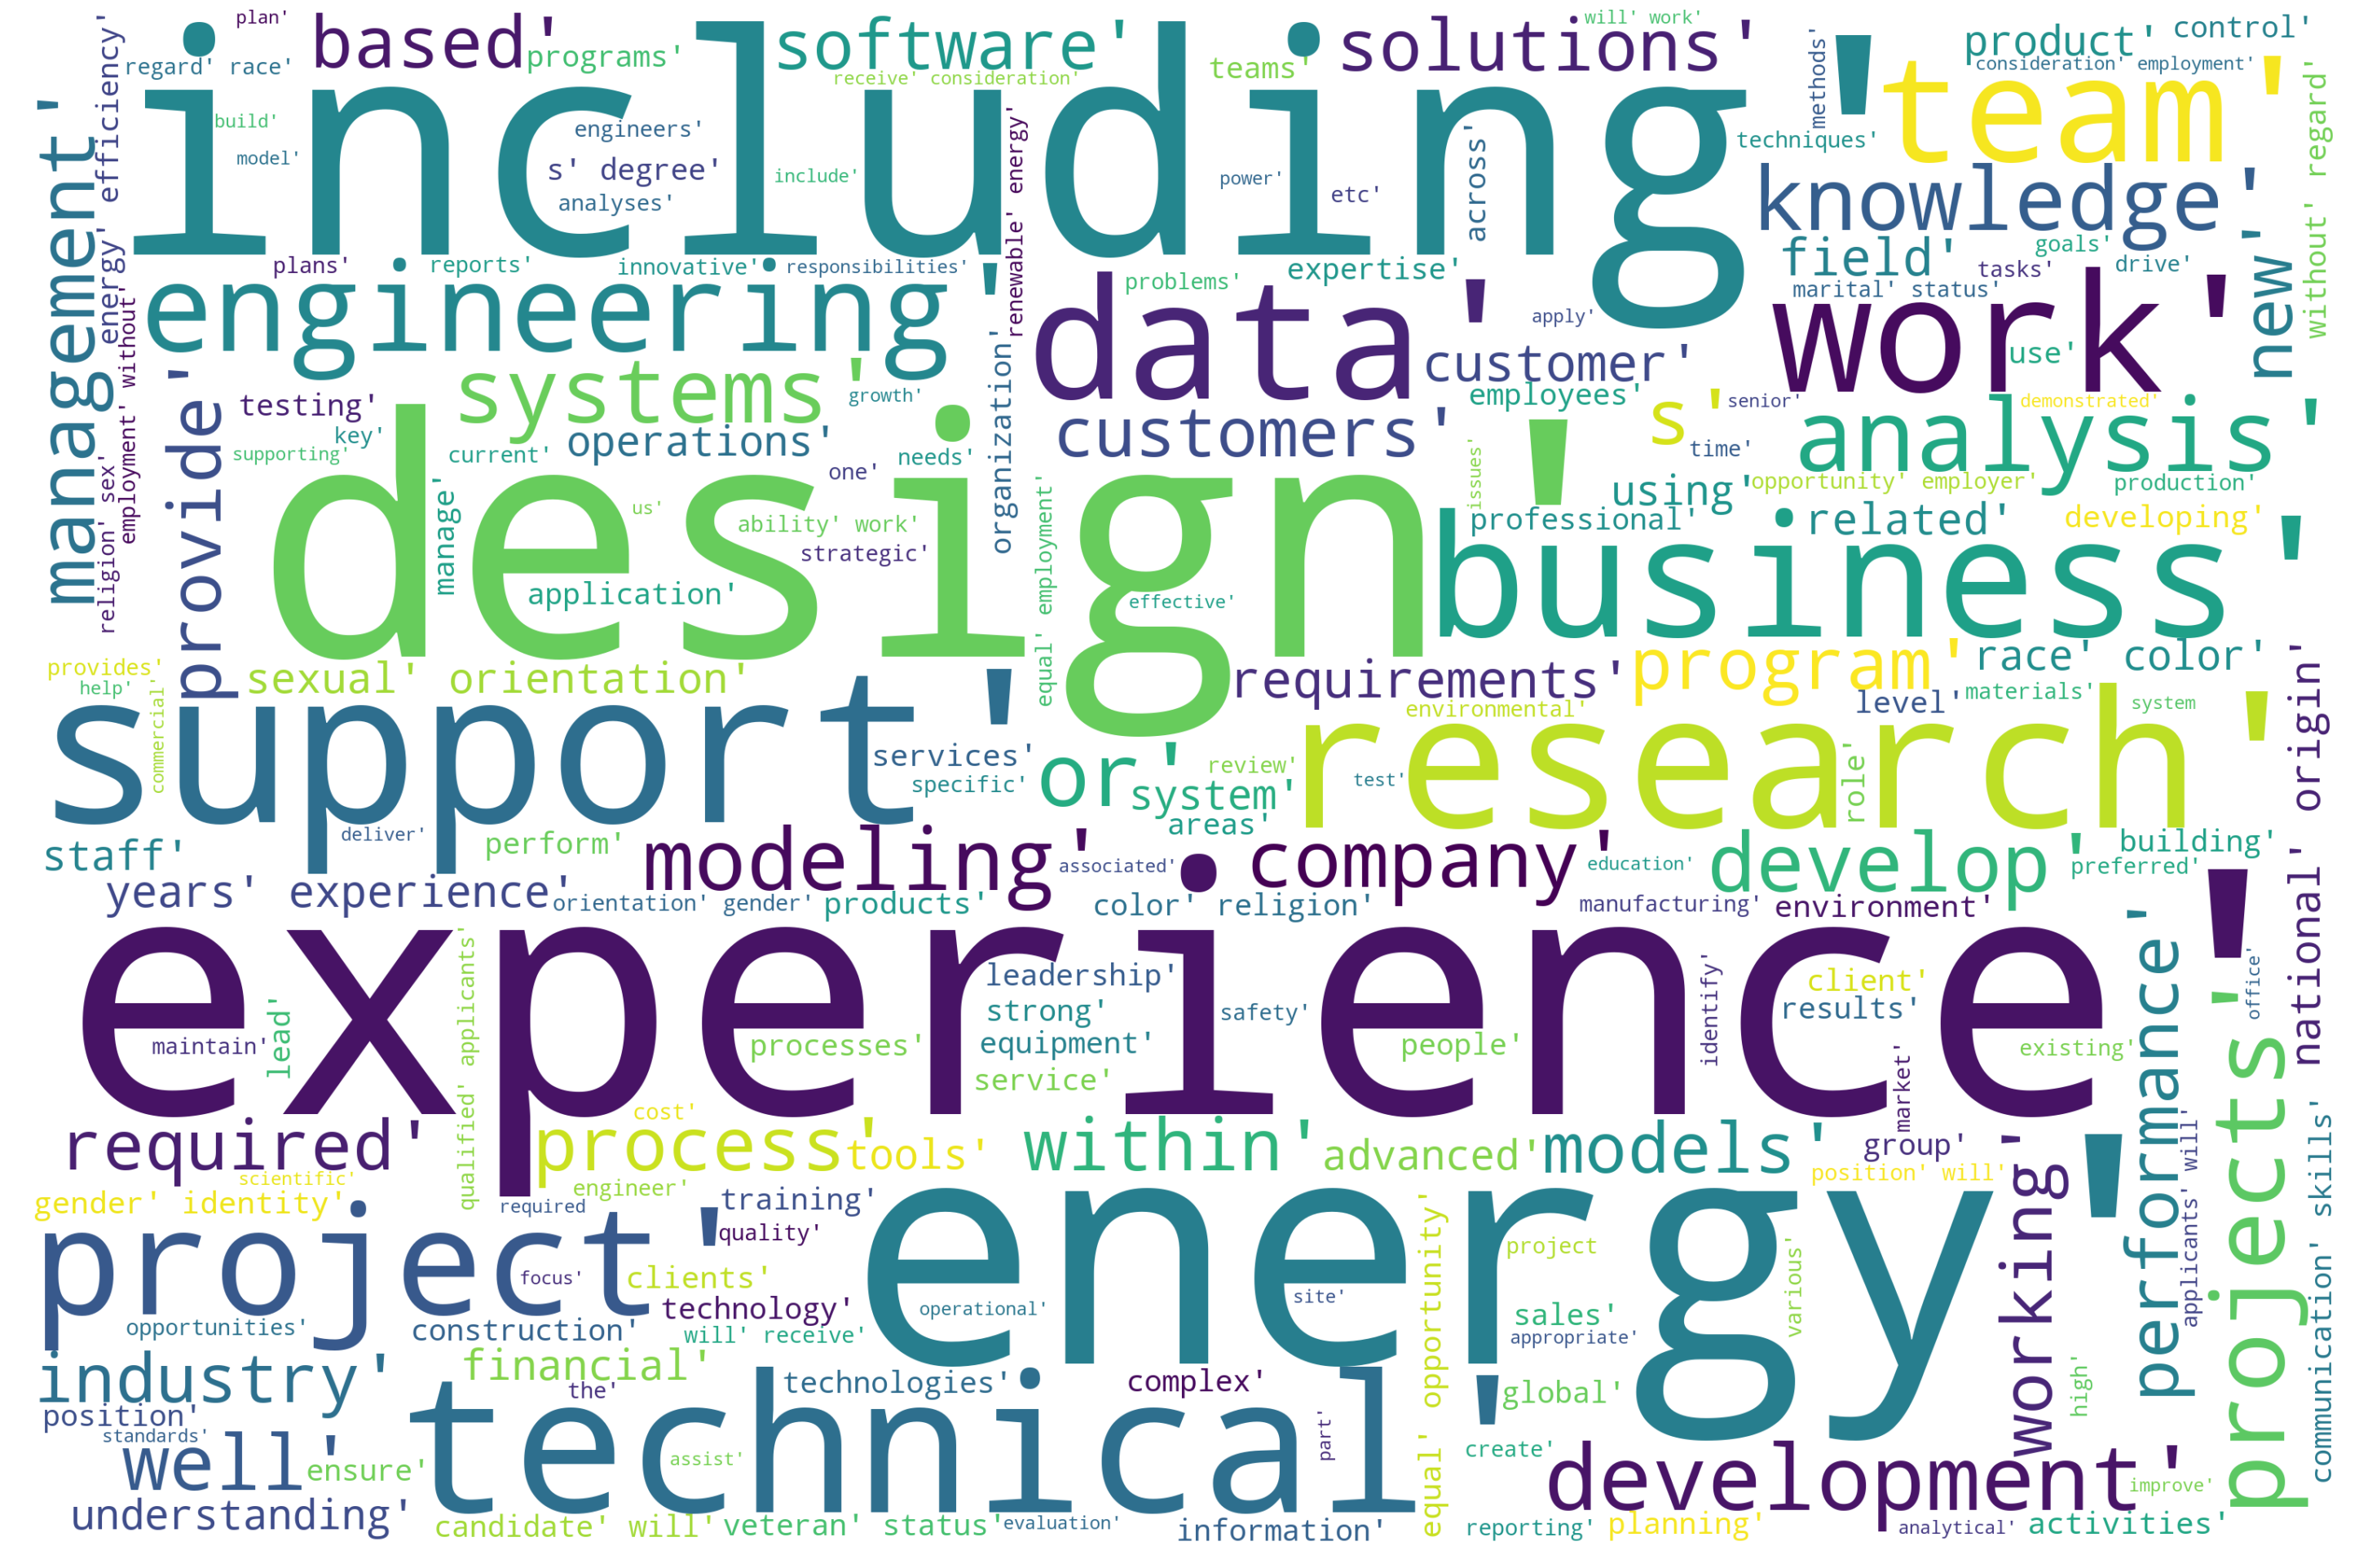

In [104]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = useless_words).generate(str(clean_flat))
fig = plt.figure(
    figsize = (40, 30))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The top words are energy, experience, design, support, business, including, project, data, modeling, analysis, technical, and more. 

I'm not sure why some words has the apostrophe following behind. It may come from tokenizing the words. We shall move on to the analysis. 

### States Map
Let's look at the number of job posting all over America. 

In [142]:
import folium
import json
from pandas.io.json import json_normalize

In [106]:
cleanjobs['Location'].unique()

array(['San Francisco, CA', 'Rosemead, CA 91771', 'Irving, TX',
       'Newark, NJ 07102 (Central Business District area)', 'Denver, CO',
       'Golden, CO 80401', 'San Diego, CA', 'United States',
       'Napa, CA 94558', 'Sacramento, CA 95828', 'Boulder, CO',
       'New York, NY', 'Pittsburgh, PA', 'Newark, CA', 'Washington, DC',
       'Dearborn, MI 48126', 'Chicago, IL 60606 (Loop area)',
       'Bartlesville, OK', 'Freeport, PA',
       'Houston, TX 77075 (Southeast area)', 'Encinitas, CA 92024',
       'Houston, TX', 'Houston, TX 77032', 'Lawrenceville, NJ 08648',
       'Miami, FL', 'Redmond, WA 98052',
       'Chicago, IL 60607 (Near West Side area)', 'Park Ridge, IL 60068',
       'Houston, TX 77079 (West Houston area)', 'Auburn Hills, MI',
       'Altamonte Springs, FL', 'Philadelphia, PA', 'Pipersville, PA',
       'Upper Providence, PA', 'Andover, MA 01810', 'Lyndhurst, NJ',
       'Cincinnati, OH 45236', 'Atlanta, GA 30318', 'Remote',
       'Westwood, MA', 'Boston, MA',

In [124]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [150]:
#read the states_titlecase.json
states_titlecase = 'geo/states_titlecase.json'
states_match = json.load(open(states_titlecase,'rb'))
states_match_df = json_normalize(states_match)
states_match_df = states_match_df.rename(columns={'abbreviation':'States','name':'StatesName'})
states_match_df.head(2)

,States,StatesName
0,AL,Alabama
1,AK,Alaska


In [151]:
#Want to keep the capitalization because that's how abbreviation are written
states_df = []
for word in states:
    count_job = cleanjobs.Location.str.count(word).sum()
    states_df.append([word,count_job])
states_df = pd.DataFrame(states_df, columns=['States','FrequencyCount'])
states_df = states_df.sort_values(by='FrequencyCount',ascending=False)
states_df= states_df.reset_index(drop=True)
states_result = states_df.merge(states_match_df,  on='States')
states_result.head()

,States,FrequencyCount,StatesName
0,CA,122,California
1,CO,50,Colorado
2,NY,48,New York
3,TX,38,Texas
4,IL,28,Illinois


In [167]:
# All jobs in clean jobs
cleanjobs.shape

(603, 10)

In [165]:
# Number of jobs with associated State abbreviation in their Location field
states_result['FrequencyCount'].sum()

587

In [126]:
#import geocode
states_geo = 'geo/gz_2010.json'

In [172]:
#plotting
map = folium.Map(location=[37, -100], zoom_start=3.5)

#label for legend
legend_indicator = states_df.iloc[0]['States']

# choropleth maps bind Pandas Data Frames and json geometries.  This allows us to quickly visualize data combinations
map.choropleth(geo_data=states_geo, data=states_result,
             columns=['StatesName', 'FrequencyCount'],
             key_on='feature.properties.NAME',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name=legend_indicator)
#create the folium plot
map.save('states_result.html')

# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=states_result.html width=700 height=450></iframe>')

C:\Users\-\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


California stoods out to have the highest number of job bulletins. 

### Who are the top employers?

In [215]:
cleanjobs['Company'] = cleanjobs['Company'].str.strip()

In [216]:
company_array = cleanjobs['Company'].unique()
company_list = company_array.tolist()

In [217]:
len(company_list)

401

In [220]:
companies_df = []
for word in company_list:
    count_job = cleanjobs.Company.str.count(word).sum()
    companies_df.append([word,count_job])
companies_df = pd.DataFrame(companies_df, columns=['Companies','FrequencyCount'])
companies_df = companies_df.sort_values(by='FrequencyCount',ascending=False)
companies_df= companies_df.reset_index(drop=True)
companies_df[0:10]

,Companies,FrequencyCount
0,National Renewable Energy Laboratory,23
1,Sandia National Laboratories,14
2,Lucid Motors,10
3,Lawrence Livermore National Laboratory,8
4,ATI,7
5,Pacific Northwest National Laboratory,7
6,ASML,7
7,Lawrence Berkeley National Laboratory,6
8,Wood,6
9,Golder Associates,6


From my domain knowledge, we can see that there are employers who typically don't hire energy modelers, but they do show up on the search. For instance, let's look at one of the companies.

In [219]:
cleanjobs[cleanjobs['Company'] == 'Lucid Motors']

,Job_title,Company,Location,Raw JobID,Date Posted,JobID,Link,Job Description,Job_title_temp,Jobdes_temp
90,Senior Engineer Battery Lifetime P...,Lucid Motors,"Newark, CA",jl_cc284a38c5f9254e,30+ days ago,cc284a38c5f9254e,https://www.indeed.com/viewjob?jk=cc284a38c5f9...,Leading the future of luxury mobilityLucid’s m...,senior engineer battery lifetime p...,leading the future of luxury mobilitylucid’s m...
300,Hard Modeler,Lucid Motors,"Newark, CA",jl_901418c15c4e846d,27 days ago,901418c15c4e846d,https://www.indeed.com/viewjob?jk=901418c15c4e...,Leading the future of luxury mobilityLucid’s m...,hard modeler,leading the future of luxury mobilitylucid’s m...
882,Modeling and Simulation Engineer ADAS/AD,Lucid Motors,"Newark, CA",jl_6f3bcdaa1f6f1e76,30+ days ago,6f3bcdaa1f6f1e76,https://www.indeed.com/viewjob?jk=6f3bcdaa1f6f...,Leading the future of luxury mobilityLucid’s m...,modeling and simulation engineer adas/ad,leading the future of luxury mobilitylucid’s m...
1161,"Engineer, Battery Systems",Lucid Motors,"Newark, CA",jl_5a8da3ac23f4660d,30+ days ago,5a8da3ac23f4660d,https://www.indeed.com/viewjob?jk=5a8da3ac23f4...,Leading the future of luxury mobilityLucid’s m...,"engineer, battery systems",leading the future of luxury mobilitylucid’s m...
1284,CAE Engineer Durability,Lucid Motors,"Newark, CA",jl_f671e2164411777a,30+ days ago,f671e2164411777a,https://www.indeed.com/viewjob?jk=f671e2164411...,Leading the future of luxury mobilityLucid’s m...,cae engineer durability,leading the future of luxury mobilitylucid’s m...
1299,Fastener Engineer,Lucid Motors,"Newark, CA",jl_eca4c493fa041655,30+ days ago,eca4c493fa041655,https://www.indeed.com/viewjob?jk=eca4c493fa04...,Leading the future of luxury mobilityLucid’s m...,fastener engineer,leading the future of luxury mobilitylucid’s m...
1311,"Senior Engineer, Battery Algorithms",Lucid Motors,"Newark, CA",jl_38deed3774a277be,30+ days ago,38deed3774a277be,https://www.indeed.com/viewjob?jk=38deed3774a2...,Leading the future of luxury mobilityLucid’s m...,"senior engineer, battery algorithms",leading the future of luxury mobilitylucid’s m...
1365,NVH CAE Engineer,Lucid Motors,"Newark, CA",jl_e2572f54b2ae9dc2,30+ days ago,e2572f54b2ae9dc2,https://www.indeed.com/viewjob?jk=e2572f54b2ae...,Leading the future of luxury mobilityLucid’s m...,nvh cae engineer,leading the future of luxury mobilitylucid’s m...
1668,"Power Electronics Engineer, Hardwa...",Lucid Motors,"Newark, CA",jl_98f583aee73f07ee,30+ days ago,98f583aee73f07ee,https://www.indeed.com/viewjob?jk=98f583aee73f...,Leading the future of luxury mobilityLucid’s m...,"power electronics engineer, hardwa...",leading the future of luxury mobilitylucid’s m...
2262,"Mechanical Engineer, E-Machine and...",Lucid Motors,"Newark, CA",jl_b937b9660a4edf12,30+ days ago,b937b9660a4edf12,https://www.indeed.com/viewjob?jk=b937b9660a4e...,Leading the future of luxury mobilityLucid’s m...,"mechanical engineer, e-machine and...",leading the future of luxury mobilitylucid’s m...


This indicates that further cleaning of the data is needed to filter out non-relevant jobs for the next iterative of data-cleaning and preparation that would focus the results for energy modeling within the Building Construction industry. This is an example of domain knowledge help refine the quality of the dataset.

# Data Analysis: Finding Gender Bias
* Apply Sentiment Analysis : Unconscious Gender Bias Words (inspired by and also provided list of words: https://www.kaggle.com/shivamb/2-encourage-diversity-reduce-bias-cola) 
    * High use of Gendered Keywords: 'assertive', 'aggressive', 'independent', rather than 'conscientious','dedicated', 'sociable'
    * Type of superlative usage
    * Demanding requirements
    * Gender Bias: Job titles, Seniority Levels
     

#### Data Sets (as a reminder for myself)
* cleanjobs = the dataframe with all the information
* clean_flat = a list of all the job description, tokenized 

In [241]:
#Let's check out tokenized words
clean_flat[40:50] 

['level',
 'support',
 'serve',
 'clients.this',
 'full-time',
 'non-exempt',
 'role',
 'reporting',
 'senior',
 'director']

Overall, it looks good. There might be some words that have been stuck due to missing 'space' in the original text. Example: clients.this. This can be improved in the next iteration of data cleaning.

In [292]:
#Looking at the distinct words
percent_word = len(set(clean_flat)) / len(clean_flat) * 100
print("Percent of words: ", percent_word)
print("Number of distinct words: ", len(set(clean_flat)))

Percent of words:  9.070314327575382
Number of distinct words:  22101


In [291]:
sorted(w for w in set(clean_flat) if 'senior' in w)

['mid-to-senior',
 'relayingsenior',
 'responsibilitiessenior',
 'senior',
 'senior-level',
 'summarysenior']

In [293]:
#Import masculine and fem words
masculine =  ['active', 'adventurous', 'aggress', 'ambitio', 'analy', 'assert', 'athlet', 'autonom', 'battle', 'boast', 'challeng', 'champion', 'compet', 'confident', 'courag', 'decid', 'decision', 'decisive', 'defend', 'determin', 'domina', 'dominant', 'driven', 'fearless', 'fight', 'force', 'greedy', 'head strong', 'headstrong', 'hierarch', 'hostil', 'impulsive', 'independen', 'individual', 'intellect', 'lead', 'logic', 'objective', 'opinion', 'outspoken', 'persist', 'principle', 'reckless', 'self confiden', 'self relian', 'self sufficien', 'selfconfiden', 'selfrelian', 'selfsufficien', 'stubborn', 'superior', 'unreasonab', 'capable', 'certain', 'focus', 'benefit', 'trust ', 'trusting', 'acceptance ', 'accepting', 'appreciative ', 'appreciation', 'admire ', 'admiration', 'approval', 'encouragement', 'power', 'strenght', 'competency ', 'competence', 'efficient ', 'efficiency', 'achievement', 'honor', 'pride', 'dignity', 'solution ', 'solutions', 'success', 'skills', 'autonomy', 'love', 'serve', 'support', 'give ', 'giving', 'provide', 'devoted', 'fulfill', 'caretaker', 'space', 'useful', 'rational', 'strategy ', 'strategic', 'plan ', 'planning', 'analytic ', 'analytical', 'reasonable', 'consider', 'analyse ', 'analysing', 'believe', 'opinion', 'suggestion', 'think', 'prove themselves', 'achieve results', 'feel good about himself', 'doing things by himself', 'loving acceptance', 'feeling needed', 'someone to serve', 'good enough', 'fulfill others', 'silent acceptance', 'comforting love', 'common sense', 'point of view', 'active', 'adventurous', 'aggress', 'ambitio', 'analy', 'assert', 'athlet', 'autonom', 'boast', 'challeng', 'compet', 'confident', 'courag', 'decide', 'decisive', 'decision', 'determin', 'dominant', 'domina', 'force', 'greedy', 'headstrong', 'hierarch', 'hostil', 'implusive', 'independen', 'individual', 'intellect', 'lead', 'logic', 'masculine', 'objective', 'opinion', 'outspoken', 'persist', 'principle', 'reckless', 'stubborn', 'superior', 'self confiden', 'self sufficien', 'self relian']
feminine = ['agree', 'affectionate', 'child', 'cheer', 'collab', 'commit', 'communal', 'compassion', 'connect', 'considerate', 'cooperat', 'co operat', 'depend', 'emotiona', 'empath', 'feel', 'flatterable', 'gentle', 'honest', 'interdependen', 'interpersona', 'inter personal', 'inter dependen', 'inter persona', 'kind', 'kinship', 'loyal', 'modesty', 'nag', 'nurtur', 'pleasant', 'polite', 'quiet', 'respon', 'sensitiv', 'submissive', 'support', 'sympath', 'tender', 'together', 'trust', 'understand', 'warm', 'whin', 'enthusias', 'inclusive', 'yield', 'share', 'sharin', 'affectionate', 'child', 'cheer', 'commit', 'communal', 'compassion', 'connect', 'considerate', 'cooperat', 'depend', 'emotiona', 'empath', 'feminine', 'flatterable', 'gentle', 'honest', 'interdependen', 'interpersona', 'kindkinship', 'loyal', 'modesty', 'nag', 'nurtur', 'pleasant', 'polite', 'quiet', 'respon', 'sensitiv', 'submissive', 'support', 'sympath', 'tender', 'together', 'trust', 'understand', 'warm', 'whin', 'yield', 'ease', 'permission', 'kindness', 'appreciation', 'caring', 'respect', 'devotion', 'validation', 'reassurance', 'respectful', 'love', 'communication', 'beauty', 'relationships', 'helping', 'sharing', 'relating', 'harmony', 'community', 'talking', 'intimate', 'life', 'healing', 'growth', 'intuitive', 'companionship', 'receive ', 'receiving', 'cherished', 'creativity', 'reassurance', 'worthy', 'supported ', 'supporting', 'nurture ', 'nurturing ', 'nurtured', 'feel', 'emotion']
superlatives = ['expert', 'perfection', 'rockstar', 'specialist', 'authority', 'pundit', 'oracle', 'resource person', 'adept', 'maestro', 'virtuoso', 'master', 'past master', 'professional', 'genius', 'wizard', 'connoisseur', 'aficionado', 'cognoscenti', 'cognoscente', 'doyen', 'savant', 'ace', 'buff', 'ninja', 'pro', 'whizz', 'hotshot', 'old hand', 'alpha geek', 'dab hand', 'maven', 'crackerjack']
relationships = ['family', 'child', 'parent', 'women', 'mother', 'father', 'son', 'daughter', 'kids', 'kid', 'married', 'household', 'home', 'sibling']
strict_words = ['disqualified', 'rejected', 'must', 'should', 'required', 'banned', 'barred', 'disbarred', 'debarred', 'eliminated', 'precluded', 'disentitled', 'ineligible', 'unfit', 'unqualified', 'essential', 'desirable', 'desired']
strict_phrases = ['only be', 'who fail', 'not allowed', 'should have', 'is required', 'subject to', 'will not be considered', 'cannot be appointed', 'who lack']
mas_pronouns = ["he", "his", "him", "himself"]
fem_pronouns = ["she", "her", "herself"]

In [304]:
jobbias_df = cleanjobs.drop(['Raw JobID', 'Job Description','Job_title'], axis=1)
jobbias_df.rename(columns={'Job_title_temp': 'Job_Title', 'Jobdes_temp' : 'Job_Description'}, inplace=True)
jobbias_df.head(2)


,Company,Location,Date Posted,JobID,Link,Job_Title,Job_Description
0,3Degrees,"San Francisco, CA",2 hours ago,7ec62b1fa6e18577,https://www.indeed.com/viewjob?jk=7ec62b1fa6e1...,"associate, energy & climate practice","about youyou are someone who loves to analyze,..."
3,Southern California Edison,"Rosemead, CA 91771",26 days ago,857108d858e6339d,https://www.indeed.com/viewjob?jk=857108d858e6...,recent graduate: clean energy analyst,job descriptionenergy for what’s aheadare you ...


## Objective of Analysis
1. Count all the fem / mas words of ALL description. Similar to the word cloud in the Exploratory Data step before.
2. For each job description, I want to count and sum up the number of masculine and femn words.
3. Create category or a dictionary of Job Titles or categories of jobs and see which job title tend to have more bias.


#### 1. Overall count from all the job descriptions

In [329]:
def bias_count_list(category, list_name):
    count_total = sum(x in category for x in list_name)
    return count_total

In [ ]:
#Adding back the pronouns
pronouns = mas_pronouns + fem_pronouns
useless_wpronouns = [item for item in useless_words if item not in pronouns]
#Test
pronouns in useless_wpronouns

In [ ]:
clean_flat_pronouns = [w for w in flat_alldes if not w in useless_wpronouns and len(w) > 1]

In [412]:
#All of Job Description with clean_flat
print("Masculine Words: " , bias_count_list(masculine, clean_flat))
print("Feminine Words: " , bias_count_list(feminine, clean_flat))
print("Superlatives Words: " , bias_count_list(superlatives, clean_flat))
print("Relationships Words: " , bias_count_list(relationships, clean_flat))
#print("Strict Words: " , bias_count(strict_words, jobbias_df))
print("Masculine Pronouns Words: " , bias_count_list(mas_pronouns, clean_flat))
print("Feminine Pronouns Words: " , bias_count_list(fem_pronouns, clean_flat))

Masculine Words:  6088
Feminine Words:  2933
Superlatives Words:  659
Relationships Words:  168
Masculine Pronouns Words:  0
Feminine Pronouns Words:  0


In [413]:
#All of Job Description with clean_flat_pronouns
print("Masculine Words: " , bias_count_list(masculine, clean_flat_pronouns))
print("Feminine Words: " , bias_count_list(feminine, clean_flat_pronouns))
print("Superlatives Words: " , bias_count_list(superlatives, clean_flat_pronouns))
print("Relationships Words: " , bias_count_list(relationships, clean_flat_pronouns))
print("Masculine Pronouns Words: " , bias_count_list(mas_pronouns, clean_flat_pronouns))
print("Feminine Pronouns Words: " , bias_count_list(fem_pronouns, clean_flat_pronouns))

Masculine Words:  5631
Feminine Words:  2811
Superlatives Words:  629
Relationships Words:  159
Masculine Pronouns Words:  19
Feminine Pronouns Words:  17


#### Looking at which highly used masculine words

In [526]:
mas_df = []
for word in masculine:
    count_job = clean_flat_pronouns.count(word)
    mas_df.append([word,count_job])
mas_df = pd.DataFrame(mas_df, columns=['Word','FrequencyCount'])
mas_df = mas_df.sort_values(by='FrequencyCount',ascending=False)
mas_df= mas_df.reset_index(drop=True)

[Text(0, 0.5, 'Words'),
 (0, 1000),
 Text(0.5, 0, 'Frequency'),
 Text(0.5, 1.0, 'Top Masculine Words')]

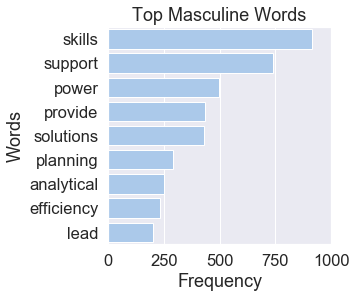

In [913]:
f, ax = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.5)
sns.set_color_codes("pastel")
sns.barplot(x="FrequencyCount", y="Word", data=mas_df[0:10],
            color="b")
ax.set(xlim=(0,1000),ylabel="Words", xlabel="Frequency", title="Top Masculine Words")

In [545]:
fem_df = []
for word in feminine:
    count_job = clean_flat_pronouns.count(word)
    fem_df.append([word,count_job])
fem_df = pd.DataFrame(fem_df, columns=['Word','FrequencyCount'])
fem_df = fem_df.sort_values(by='FrequencyCount',ascending=False)
fem_df= fem_df.reset_index(drop=True)

[Text(0, 0.5, 'Words'),
 (0, 1000),
 Text(0.5, 0, 'Frequency'),
 Text(0.5, 1.0, 'Top Feminine Words')]

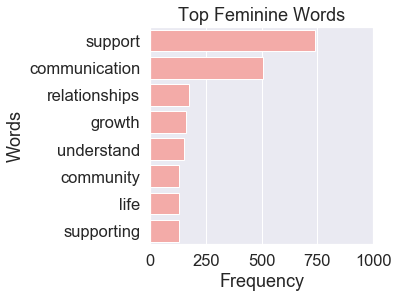

In [914]:
f, ax = plt.subplots(figsize=(4, 4))
sns.set_color_codes("pastel")
sns.barplot(x="FrequencyCount", y="Word", data=fem_df[0:10],
            color="r")
ax.set(xlim=(0,1000),ylabel="Words", xlabel="Frequency", title="Top Feminine Words")

[Text(0, 0.5, 'Words'),
 (0, 400),
 Text(0.5, 0, 'Frequency'),
 Text(0.5, 1.0, 'Top Superlatives Words')]

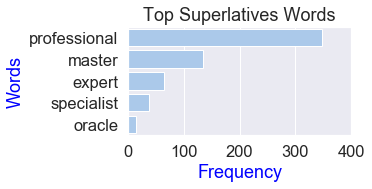

In [1394]:
sl_df = []
for word in superlatives:
    count_job = clean_flat_pronouns.count(word)
    sl_df.append([word,count_job])
sl_df = pd.DataFrame(sl_df, columns=['Word','FrequencyCount'])
sl_df = sl_df.sort_values(by='FrequencyCount',ascending=False)
sl_df= sl_df.reset_index(drop=True)

f, ax = plt.subplots(figsize=(4, 2))
#sns.set_color_codes("pastel")
sns.barplot(x="FrequencyCount", y="Word", data=sl_df[0:5], color="b")
ax.set(xlim=(0,400),ylabel="Words", xlabel="Frequency", title="Top Superlatives Words")

[Text(0, 0.5, 'Words'),
 (0, 400),
 Text(0.5, 0, 'Frequency'),
 Text(0.5, 1.0, 'Top Relationships Words')]

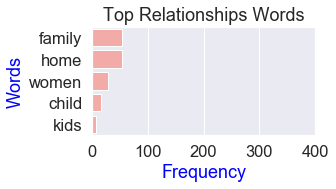

In [1159]:
rel_df = []
for word in relationships:
    count_job = clean_flat_pronouns.count(word)
    rel_df.append([word,count_job])
rel_df = pd.DataFrame(rel_df, columns=['Word','FrequencyCount'])
rel_df = rel_df.sort_values(by='FrequencyCount',ascending=False)
rel_df= rel_df.reset_index(drop=True)

f, ax = plt.subplots(figsize=(4, 2))
sns.set_color_codes("pastel")
sns.barplot(x="FrequencyCount", y="Word", data=rel_df[0:5],
            color="r")
ax.set(xlim=(0,400),ylabel="Words", xlabel="Frequency", title="Top Relationships Words")

#### 2. Creating categorical columns for each position.

In [407]:
def bias_mas(txt):
    token = word_tokenize(txt)
    #clean up token 
    token_clean = [w for w in token if not w in useless_wpronouns and len(w) > 1]
    #find masculine words 
    w_count = sum(x in masculine for x in token_clean)
    return w_count
#return a list of tokenized words

def bias_fem(txt):
    token = word_tokenize(txt) 
    token_clean = [w for w in token if not w in useless_wpronouns and len(w) > 1]
    w_count = sum(x in feminine for x in token_clean)
    return w_count

def bias_superlatives(txt):
    token = word_tokenize(txt) 
    token_clean = [w for w in token if not w in useless_wpronouns and len(w) > 1]
    w_count = sum(x in superlatives for x in token_clean)
    return w_count

def bias_relationships(txt):
    token = word_tokenize(txt) 
    token_clean = [w for w in token if not w in useless_wpronouns and len(w) > 1]
    w_count = sum(x in relationships for x in token_clean)
    return w_count

def bias_fem_pronouns(txt):
    token = word_tokenize(txt) 
    token_clean = [w for w in token if not w in useless_wpronouns and len(w) > 1]
    w_count = sum(x in fem_pronouns for x in token_clean)
    return w_count

def bias_mas_pronouns(txt):
    token = word_tokenize(txt) 
    token_clean = [w for w in token if not w in useless_wpronouns and len(w) > 1]
    w_count = sum(x in mas_pronouns for x in token_clean)
    return w_count

In [403]:
sum(jobbias_df['Job_Description'].isnull())

8

In [404]:
jobbias_df = jobbias_df.dropna(axis=0, subset=['Job_Description'])

In [408]:
jobbias_df['Masculine_WCount'] = jobbias_df['Job_Description'].apply(lambda x: bias_mas(x))
jobbias_df['Feminine_WCount'] = jobbias_df['Job_Description'].apply(lambda x: bias_fem(x))
jobbias_df['Superlatives_WCount'] = jobbias_df['Job_Description'].apply(lambda x: bias_superlatives(x))
jobbias_df['Relationships_WCount'] = jobbias_df['Job_Description'].apply(lambda x: bias_relationships(x))
jobbias_df['FemPronouns_WCount'] = jobbias_df['Job_Description'].apply(lambda x: bias_fem_pronouns(x))
jobbias_df['MasPronouns_WCount'] = jobbias_df['Job_Description'].apply(lambda x: bias_mas_pronouns(x))

In [409]:
jobbias_df.head()

,Company,Location,Date Posted,JobID,Link,Job_Title,Job_Description,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,FemPronouns_WCount,MasPronouns_WCount
0,3Degrees,"San Francisco, CA",2 hours ago,7ec62b1fa6e18577,https://www.indeed.com/viewjob?jk=7ec62b1fa6e1...,"associate, energy & climate practice","about youyou are someone who loves to analyze,...",20,6,3,0,0,0
3,Southern California Edison,"Rosemead, CA 91771",26 days ago,857108d858e6339d,https://www.indeed.com/viewjob?jk=857108d858e6...,recent graduate: clean energy analyst,job descriptionenergy for what’s aheadare you ...,24,4,0,0,0,0
6,US-EcoLogic,"Irving, TX",3 days ago,b61acdd3af88f3f9,https://www.indeed.com/viewjob?jk=b61acdd3af88...,energy modeling engineer,"worksite address: 911 maryland drive, irving, ...",1,0,1,1,0,0
12,Deloitte,"San Francisco, CA",25 days ago,afcd7eefa31c59f7,https://www.indeed.com/viewjob?jk=afcd7eefa31c...,"valuation & modeling consultant,",valuation & modeling – financial modeling cons...,25,11,2,0,0,0
15,Lime Energy,"Newark, NJ 07102 (Central Business District area)",30+ days ago,325e571e6bd83a42,https://www.indeed.com/viewjob?jk=325e571e6bd8...,energy auditor,energy auditorjob summary:to support the rapid...,2,2,0,0,0,0


In [418]:
jobbias_df['MasFem_Diff'] = jobbias_df['Masculine_WCount'] - jobbias_df['Feminine_WCount']

[Text(0, 0.5, 'Feminine Word Counts'), Text(0.5, 0, 'Masculine Word Counts')]

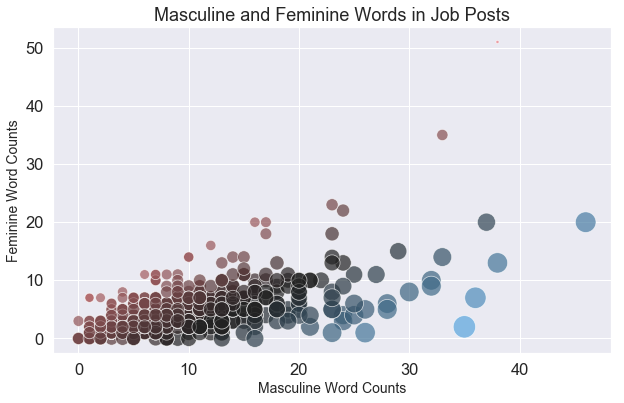

In [918]:
#Plot of all job bulletins Masculine vs Feminine words choice
# construct cmap
my_cmap = sns.diverging_palette(10, 240, l=65, center="dark", as_cmap=True)
#my_cmap = sns.light_palette("Red", as_cmap=True)
plt.figure(figsize=(10,6))
plt.title("Masculine and Feminine Words in Job Posts", size=18)
plt.ylabel("Feminine Words Count", size=14)
plt.xlabel("Masculine Words Count", size=14)
ax = sns.scatterplot(x="Masculine_WCount", y="Feminine_WCount", data=jobbias_df,
                    size = jobbias_df['MasFem_Diff'], sizes=(10,500),
                    hue = jobbias_df['MasFem_Diff'], palette=my_cmap,
                    hue_order=[jobbias_df['MasFem_Diff'].max()*-1,jobbias_df['MasFem_Diff'].max()],
                    legend=False, alpha = 0.7)
ax.set(ylabel="Feminine Word Counts", xlabel="Masculine Word Counts")

#### Listing positions with high masculinity and femininity bias
Let's look at the jobs that have the popular key words in the title (from previous analysis):
* engineer
* energy
* analyst
* research
* data

In [930]:
jobbias_df.head(2)

,Company,Location,Date Posted,JobID,Link,Job_Title,Job_Description,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,FemPronouns_WCount,MasPronouns_WCount,MasFem_Diff,k_Cluster
0,3Degrees,"San Francisco, CA",2 hours ago,7ec62b1fa6e18577,https://www.indeed.com/viewjob?jk=7ec62b1fa6e1...,"associate, energy & climate practice","about youyou are someone who loves to analyze,...",20,6,3,0,0,0,14,3
3,Southern California Edison,"Rosemead, CA 91771",26 days ago,857108d858e6339d,https://www.indeed.com/viewjob?jk=857108d858e6...,recent graduate: clean energy analyst,job descriptionenergy for what’s aheadare you ...,24,4,0,0,0,0,20,3


In [1308]:
Topjobs = ['engineer','analyst','research','data','energy'] #remove energy
jobbias_df['JobType'] = jobbias_df['Job_Title'].apply(lambda x: ','.join([i for i in Topjobs if i in x]))
jobbias_df.head()

,Company,Location,Date Posted,JobID,Link,Job_Title,Job_Description,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,FemPronouns_WCount,MasPronouns_WCount,MasFem_Diff,k_Cluster,JobType,Mas_Fem_Ratio
0,3Degrees,"San Francisco, CA",2 hours ago,7ec62b1fa6e18577,https://www.indeed.com/viewjob?jk=7ec62b1fa6e1...,"associate, energy & climate practice","about youyou are someone who loves to analyze,...",20,6,3,0,0,0,14,3,energy,3.333333
3,Southern California Edison,"Rosemead, CA 91771",26 days ago,857108d858e6339d,https://www.indeed.com/viewjob?jk=857108d858e6...,recent graduate: clean energy analyst,job descriptionenergy for what’s aheadare you ...,24,4,0,0,0,0,20,3,"analyst,energy",6.000000
6,US-EcoLogic,"Irving, TX",3 days ago,b61acdd3af88f3f9,https://www.indeed.com/viewjob?jk=b61acdd3af88...,energy modeling engineer,"worksite address: 911 maryland drive, irving, ...",1,0,1,1,0,0,1,1,"engineer,energy",inf
12,Deloitte,"San Francisco, CA",25 days ago,afcd7eefa31c59f7,https://www.indeed.com/viewjob?jk=afcd7eefa31c...,"valuation & modeling consultant,",valuation & modeling – financial modeling cons...,25,11,2,0,0,0,14,3,,2.272727
15,Lime Energy,"Newark, NJ 07102 (Central Business District area)",30+ days ago,325e571e6bd83a42,https://www.indeed.com/viewjob?jk=325e571e6bd8...,energy auditor,energy auditorjob summary:to support the rapid...,2,2,0,0,0,0,0,1,energy,1.000000


In [1309]:
jobcombo = jobbias_df['JobType'].unique().tolist()
jobcombo = [x for x in jobcombo if x != '']
jobcombo

['energy',
 'analyst,energy',
 'engineer,energy',
 'engineer',
 'research,energy',
 'data',
 'engineer,research,energy',
 'analyst',
 'analyst,data',
 'research',
 'analyst,research',
 'engineer,research',
 'data,energy',
 'analyst,research,energy',
 'engineer,analyst',
 'engineer,data']

In [1310]:
#Now that we have a list of job type. We want to see each one. 
jobcombo_df = []
#jobcombo_df = jobbias_df.groupby(['JobType'])['Masculine_WCount','Feminine_WCount','Superlatives_WCount', 
#                                              'Relationships_WCount', 'FemPronouns_WCount',
 #                                             'MasPronouns_WCount'].apply(lambda x : x.astype(int).sum())

jobcombo_df = jobbias_df.groupby(['JobType'])['Masculine_WCount','Feminine_WCount','Superlatives_WCount', 
                                              'Relationships_WCount'].agg('sum')
jobcombo_df['Count'] = jobbias_df['JobType'].value_counts()
jobcombo_df = jobcombo_df.sort_values(by='Count',ascending=False)
jobcombo_df = jobcombo_df.reset_index()
jobcombo_df = jobcombo_df[jobcombo_df.JobType !=u'']
jobcombo_df

,JobType,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,Count
1,engineer,1291,606,153,21,146
2,analyst,459,223,47,5,46
3,energy,493,192,64,10,41
4,"engineer,energy",346,124,37,4,28
5,research,198,100,18,5,28
6,data,183,85,27,5,20
7,"analyst,energy",171,66,8,1,16
8,"engineer,research",78,37,9,1,13
9,"research,energy",77,34,2,0,8
10,"analyst,research",32,10,4,0,4


In [1311]:
jobcombo_df['Count'].sum()

362

In [1312]:
test_df = np.where(jobbias_df.Job_Title.str.contains('|'.join(jobcombo)),1,0)
test_df.sum()

362

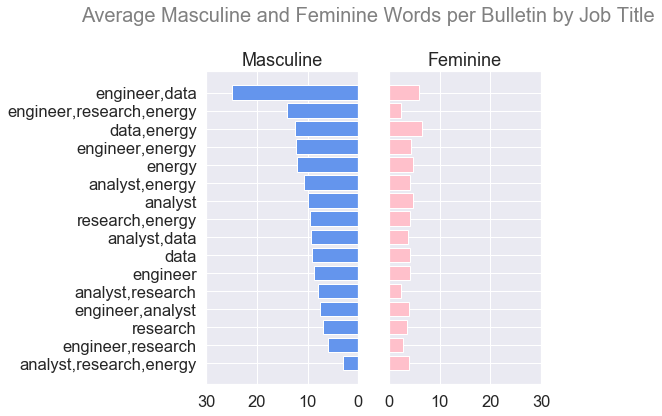

In [1342]:
jobcombo_df['Mas_Avg'] = jobcombo_df['Masculine_WCount'] / jobcombo_df['Count']
jobcombo_df['Fem_Avg'] = jobcombo_df['Feminine_WCount'] / jobcombo_df['Count']

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(6,6))
st = fig.suptitle("Average Masculine and Feminine Words per Bulletin by Job Title", fontsize=20, color='gray')

graph = jobcombo_df.sort_values(by='Mas_Avg', ascending=True)
axes[0].barh(graph['JobType'], graph['Mas_Avg'] , align='center', color='CornflowerBlue')
axes[0].set(title='Masculine',xlim=(0,30))



axes[1].barh(graph['JobType'],graph['Fem_Avg'] , align='center', color='pink')
axes[1].set(title='Feminine',xlim=(0,30))

axes[0].invert_xaxis()

# shift subplots down:
st.set_y(1)
fig.subplots_adjust(top=0.85)

plt.show()

In [1372]:
jobcombo_df['Mas_Fem_Ratio'] = jobcombo_df['Mas_Avg'] / jobcombo_df['Fem_Avg'] 
jobcombo_df['LenJobType'] = jobcombo_df['JobType'].apply(lambda x: len(x))
graph = jobcombo_df.sort_values(by='LenJobType', ascending=False)
graph

,JobType,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,Count,Mas_Avg,Fem_Avg,Mas_Fem_Ratio,LenJobType
14,"engineer,research,energy",28,5,1,0,2,14.000000,2.500000,5.600000,24
15,"analyst,research,energy",3,4,0,0,1,3.000000,4.000000,0.750000,23
8,"engineer,research",78,37,9,1,13,6.000000,2.846154,2.108108,17
10,"analyst,research",32,10,4,0,4,8.000000,2.500000,3.200000,16
13,"engineer,analyst",15,8,1,0,2,7.500000,4.000000,1.875000,16
4,"engineer,energy",346,124,37,4,28,12.357143,4.428571,2.790323,15
9,"research,energy",77,34,2,0,8,9.625000,4.250000,2.264706,15
7,"analyst,energy",171,66,8,1,16,10.687500,4.125000,2.590909,14
16,"engineer,data",25,6,0,1,1,25.000000,6.000000,4.166667,13
11,"analyst,data",37,15,4,0,4,9.250000,3.750000,2.466667,12


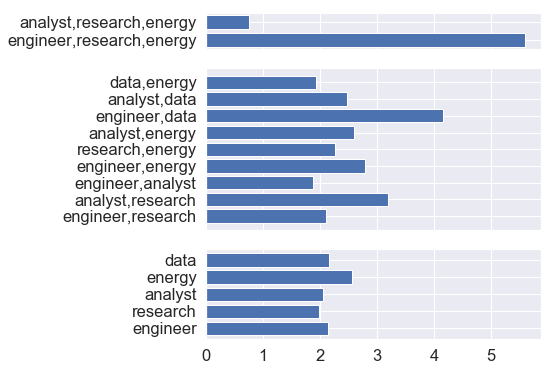

In [1390]:
from matplotlib.gridspec import GridSpec
fig, ax = plt.subplots(nrows=3, figsize=(6,6), sharex = True)

ax[0].barh( graph['JobType'][0:2],graph['Mas_Fem_Ratio'][0:2], align='center')

ax[1].barh( graph['JobType'][2:11],graph['Mas_Fem_Ratio'][2:11], align='center')

ax[2].barh( graph['JobType'][11:],graph['Mas_Fem_Ratio'][11:], align='center')

gs = GridSpec(3, 1, height_ratios = [2,9,5])
for i in range(3):
    ax[i].set_position(gs[i].get_position(f))

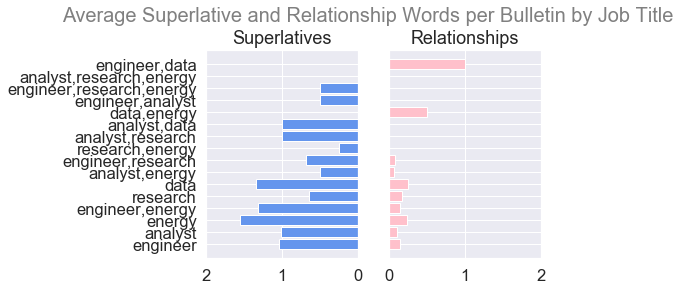

In [1315]:
fig, axes = plt.subplots(ncols=2, sharey=True)
st = fig.suptitle("Average Superlative and Relationship Words per Bulletin by Job Title", fontsize=20, color='gray')

axes[0].barh(jobcombo_df['JobType'], jobcombo_df['Superlatives_WCount'] / jobcombo_df['Count'], align='center', color='CornflowerBlue')
axes[0].set(title='Superlatives',xlim=(0,2))


axes[1].barh(jobcombo_df['JobType'], jobcombo_df['Relationships_WCount'] / jobcombo_df['Count'], align='center', color='pink')
axes[1].set(title='Relationships',xlim=(0,2))

axes[0].invert_xaxis()

# shift subplots down:
st.set_y(1)
fig.subplots_adjust(top=0.85)

plt.show()

## Data Analysis: Applying Machine Learning Methods
My goal in this analysis section is to apply a machine-learning method on the dataset that was obtained. Since the dataset is not an accumulation overtime, but only an instaneous snap shot of the job positions posted within 30-60 days timeframe, it is difficult or ***perhaps foolish*** to have enough data to feed into a model and expect high accuracy/precise results. 

Nevertheless, I want to implement a ***potential workflow*** that may work with a larger dataset (potentially happen when my data-engineering hat is on again) with a Machine Learning method. 

### Selecting a Machine Learning Methods and Reasonings: 
* Supervised vs. Unsupervised
    * Since this is a web-scraped dataset that requires iterative data cleaning and preparation, it may be better to go with Unsupervised methods instead of Supervised methods because there isn't a goal to predict a value for sort the records into certain categories. 
    * The intention of using Unsupervised method is to see what pattern can show up. 
* List of Unsupervised Methods
    * k-means - Probably use this method.
        * k value = Use the elbow method.
        * question = what similiarities are shared between subgroups?
        * features = masculine_words, feminine_words
    * Principal Component Analysis (PCA) - may not be a good application for PCA since there aren't many dimensions
   

### Unsupervised k-means clustering

In [1316]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [1317]:
jobbias_df.shape       

(595, 17)

In [1318]:
jobbias_df.describe()

,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,FemPronouns_WCount,MasPronouns_WCount,MasFem_Diff,k_Cluster,Mas_Fem_Ratio
count,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,592.000000
mean,9.463866,4.724370,1.057143,0.267227,0.028571,0.031933,4.739496,1.006723,inf
std,6.761195,4.171169,1.499751,0.919771,0.194687,0.202648,5.453294,0.866485,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.000000,0.000000,0.000000
25%,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.333333
50%,8.000000,4.000000,1.000000,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000
75%,13.000000,6.000000,1.000000,0.000000,0.000000,0.000000,7.000000,1.000000,3.200000
max,46.000000,51.000000,12.000000,13.000000,3.000000,3.000000,33.000000,4.000000,inf


In [1319]:
features = ['Masculine_WCount','Feminine_WCount','MasFem_Diff']
select_jobbias = jobbias_df[features]

In [1320]:
select_jobbias.columns

Index(['Masculine_WCount', 'Feminine_WCount', 'MasFem_Diff'], dtype='object')

#### Using Standard Scaler

What it does:

* combines fit and transform operations, which means it first calc how much data set should be transformed to be scaled
* looks at different values and finds how to scale that
* apply that tranformation to data frame we give it (select_df)
* apply the transformation it came up with to that dataframe
* the output of this function can be assigned to X

In [1321]:
X = StandardScaler().fit_transform(select_jobbias)
X

C:\Users\-\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\-\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 1.55963544,  0.30607815,  1.69957738],
       [ 2.1517446 , -0.17380722,  2.80075547],
       [-1.25288309, -1.13357796, -0.68630847],
       ...,
       [-0.51274663, -0.65369259, -0.13571943],
       [-0.36471934, -0.17380722, -0.31924911],
       [-1.1048558 , -1.13357796, -0.50277879]])

In [1322]:
#Elbow method attempt
# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])


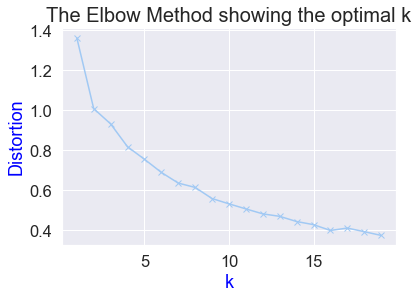

In [1323]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k', size=20)
plt.show()

The N value is not very obvious from the elbow exercise. We'll go with 5.

In [1324]:
#Picked n=3 because ideally want to separate groups into 1) masculine-bias, 2) neutral and 3) feminine-bias
kmeans = KMeans(n_clusters=5)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [1325]:
centers = model.cluster_centers_
centers

array([[ 0.43119551,  1.38755895, -0.52671744],
       [-0.70340962, -0.4075378 , -0.56039167],
       [ 0.41796388, -0.14650835,  0.63026972],
       [ 2.29360409,  0.75597068,  2.26546057],
       [ 3.85405845,  9.18395751, -2.24631076]])

In [1326]:
jobbias_df['k_Cluster'] = kmeans.predict(X)
y_kmeans = kmeans.predict(X)

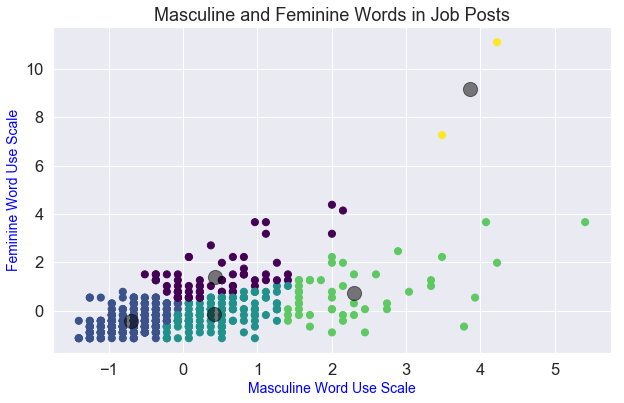

In [1327]:
plt.figure(figsize=(10,6))
plt.title("Masculine and Feminine Words in Job Posts", size=18)
plt.ylabel("Feminine Word Use Scale", size=14)
plt.xlabel("Masculine Word Use Scale", size=14)
#plt.scatter(X[:,0],X[:,1], s=50)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Expectations: 
* Group 0 - Masculine bias
* Group 1 - Neutral
* Group 2 - Feminine bias

Reality: 
* Group 0 - Words discovered in double digits, more oriented toward Masculine word
* Group 1 - Mas and Fem words between 0 to 10
* Group 2 - Words discovered in double digits (~20+) for both categories

In [1328]:
jobbias_df[jobbias_df['k_Cluster'] == 2]

,Company,Location,Date Posted,JobID,Link,Job_Title,Job_Description,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,FemPronouns_WCount,MasPronouns_WCount,MasFem_Diff,k_Cluster,JobType,Mas_Fem_Ratio
36,Clean Power Research,"Napa, CA 94558",30+ days ago,cc1ec88e71cbc416,https://www.indeed.com/viewjob?jk=cc1ec88e71cb...,renewable energy researcher,who are we?looking for a job that makes a real...,17,4,1,0,0,0,13,2,"research,energy",4.250000
42,National Renewable Energy Laboratory,"Golden, CO 80401",30+ days ago,ee3e555e6c3aecda,https://www.indeed.com/viewjob?jk=ee3e555e6c3a...,summer internship: renewable energ...,posting titlesummer internship: renewable ener...,10,3,0,0,0,0,7,2,energy,3.333333
78,EN-POWER GROUP,"New York, NY",30+ days ago,b56cccca7696a54c,https://www.indeed.com/viewjob?jk=b56cccca7696...,energy analyst and field intern,"position summary: en-power group, founded in 2...",16,4,1,0,0,0,12,2,"analyst,energy",4.000000
114,EN-POWER GROUP,"New York, NY",30+ days ago,c3d9d82d26f84d44,https://www.indeed.com/viewjob?jk=c3d9d82d26f8...,energy engineer,"position summary: en-power group, founded in 2...",18,5,2,0,0,0,13,2,"engineer,energy",3.600000
162,EN-POWER GROUP,"New York, NY",30+ days ago,30a2e2454130fcff,https://www.indeed.com/viewjob?jk=30a2e2454130...,energy analyst,"position summary: en-power group, founded in 2...",12,3,3,0,0,0,9,2,"analyst,energy",4.000000
252,National Renewable Energy Laboratory,"Golden, CO 80401",14 days ago,dc4131ba280b0cff,https://www.indeed.com/viewjob?jk=dc4131ba280b...,research engineer ii- energy optim...,posting titleresearch engineer ii- energy opti...,12,5,1,0,0,0,7,2,"engineer,research,energy",2.400000
261,EN-POWER GROUP,"New York, NY",30+ days ago,998cdfd057abb6f0,https://www.indeed.com/viewjob?jk=998cdfd057ab...,energy auditor,"position summary: en-power group, founded in 2...",13,4,2,0,0,0,9,2,energy,3.250000
336,NRG Energy,"Houston, TX",21 days ago,819bc14532a0bbc0,https://www.indeed.com/viewjob?jk=819bc14532a0...,"analyst, advisory services (distri...",nrg is the leading integrated power company in...,18,5,1,0,0,0,13,2,"analyst,energy",3.600000
348,Cardinal Financial,Remote,20 days ago,a9f872de08bb708b,https://www.indeed.com/viewjob?jk=a9f872de08bb...,senior reporting analyst | remote,who we are:cardinal financial is a nationwide ...,18,9,0,0,0,0,9,2,analyst,2.000000
351,EVERSOURCE,"Westwood, MA",11 days ago,4fca888a95e0fd4f,https://www.indeed.com/viewjob?jk=4fca888a95e0...,"analyst, energy services",check out this video and find out why our team...,12,5,0,0,0,0,7,2,"analyst,energy",2.400000


### Supervised Naive Bayes Algorithm 
Naive Bayes Algorithm is a classification technique based on Bayes' Theorem. It assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. Naive Bayes uses a similar method to predict the probability of different class based on various attributes. This algorithm is mostly used in text classification and with problems having multiple categories.

There are some limitations to the Naive Bayes method such as Zero Frequency and the assumption of independent predictators.

Some application of Naive Bayes Algorithm include text classification such as spam filtering and sentimental analysis.

Under Scikit Learn, there are 3 types: 1) Gaussian (follow normal distribution), 2) Multinomial (used for discrete counts), and 3) Bernoulli (if features are binary). 


In [1329]:
jobbias_df.columns

Index(['Company', 'Location', 'Date Posted', 'JobID', 'Link', 'Job_Title',
       'Job_Description', 'Masculine_WCount', 'Feminine_WCount',
       'Superlatives_WCount', 'Relationships_WCount', 'FemPronouns_WCount',
       'MasPronouns_WCount', 'MasFem_Diff', 'k_Cluster', 'JobType',
       'Mas_Fem_Ratio'],
      dtype='object')

In [1330]:
jobbias_df['Mas_Fem_Ratio'] = jobbias_df['Masculine_WCount']/jobbias_df['Feminine_WCount']
cleanjb_df = jobbias_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Mas_Fem_Ratio"], how="all")

In [1331]:
cleanjb_df.describe()

,Masculine_WCount,Feminine_WCount,Superlatives_WCount,Relationships_WCount,FemPronouns_WCount,MasPronouns_WCount,MasFem_Diff,k_Cluster,Mas_Fem_Ratio
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000
mean,9.678947,4.931579,1.089474,0.264912,0.028070,0.031579,4.747368,1.338596,2.549235
std,6.769913,4.139979,1.519895,0.927038,0.194615,0.202929,5.500539,0.810358,2.323401
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-13.000000,0.000000,0.000000
25%,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.300000
50%,8.000000,4.000000,1.000000,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000
75%,13.000000,6.000000,2.000000,0.000000,0.000000,0.000000,7.000000,2.000000,3.000000
max,46.000000,51.000000,12.000000,13.000000,3.000000,3.000000,33.000000,4.000000,26.000000


In [1395]:
#get the features only
features = ['Masculine_WCount','Feminine_WCount','Mas_Fem_Ratio']
X = cleanjb_df[features]
cleanjb_df['target'] = cleanjb_df['Mas_Fem_Ratio'].apply(lambda x: 1 if x < 1.25 and x > 0.75 else 0)
#cleanjb_df['target'] = (cleanjb_df['target1'] > 0.75) * 1 
y = cleanjb_df['target']

In [1396]:
#Creating a classifier
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=10)

In [1397]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()
def train_classifier(X_train, y_train):
    ### BEGIN SOLUTION
    #Naive Bayes
    classifier = gnb
    
    #kNN
    #classifier = knn
    #Decision Tree Classifier
    #classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
    
    returnval = classifier.fit(X_train, y_train)
    return returnval 

In [1398]:
min_score = 0.6
modelfit = train_classifier(X_train, y_train)
y_pred = modelfit.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.9894179894179894


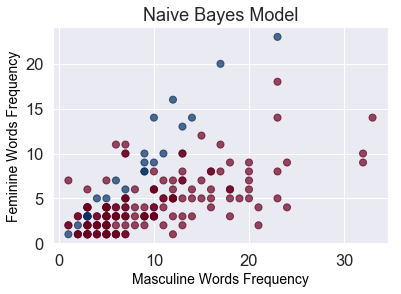

In [1409]:
plt.scatter(X_test.iloc[:,0], X_test.iloc[:,1], c=y_pred, s=50, cmap='RdBu',alpha = 0.7)
plt.title("Naive Bayes Model")
plt.xlabel("Masculine Words Frequency", color='black', fontsize=14)
plt.ylabel("Feminine Words Frequency",color='black', fontsize=14)
plt.tick_params(color='black')
    

#### Let's look at the Confusion Matrix.
A confusion matrix is a technique for summarizing the performance of a classification algorithm. It shows ways in which the model is confused when it makes the prediction. 

Text(84.18, 0.5, 'Predicted')

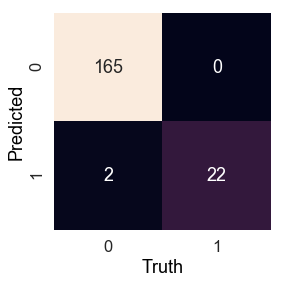

In [1523]:
mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Truth', color='black')
plt.ylabel('Predicted', color='black')

### Use model on new prediction
#### Testing My Own Resume
* Import text file
* Tokenize the text file
* Count Masculine vs Fem words, and Ratio
* Feed it into the machine learning model 
    * Bayes: modelfit
    * k-means: something here
   

In [1524]:
#from week 2
resume_path = 'myresume_long.txt'
resume_txt=open(resume_path)
wordcount={}
#remove = dict.fromkeys(map(ord, '\n' + '"' + string.punctuation))
stopwords = useless_words
for word in resume_txt.read().lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace("\"","")
    word = word.replace("“","")
    word = word.replace("–",'')
    word = word.replace("hrs/wk",'')
    word = word.replace("san",'')
    word = word.replace("diego",'')
    word = word.replace("ca",'')
    word = word.strip(' \t\n\r')
    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
d = Counter(wordcount)

for word, count in d.most_common(10):
	print(word, ": ", count)

 :  59
energy :  38
engineer :  27
building :  23
project :  15
intern :  14
facility :  13
performance :  12
student :  12
engineers :  10


In [1499]:
resume_token = list(d)

In [1500]:
myresume_df = []

In [1501]:
resume_mas = sum(x in masculine for x in resume_token)
resume_fem = sum(x in feminine for x in resume_token)
resume_sup = sum(x in superlatives for x in resume_token)
resume_rel = sum(x in relationships for x in resume_token)

In [1509]:
myresume_list = []
myresume_list.append({u'Masculine_WCount': resume_mas, u'Feminine_WCount':resume_fem})
#                     u'Superlatives_WCount': resume_sup, u'Relationships_WCount': resume_rel})
myresume_list

[{'Masculine_WCount': 8, 'Feminine_WCount': 6}]

In [1510]:
myresume_df = pd.DataFrame(myresume_list)
myresume_df['Mas_Fem_Ratio'] = myresume_df['Masculine_WCount'] / myresume_df['Feminine_WCount']
myresume_df.head()

,Feminine_WCount,Masculine_WCount,Mas_Fem_Ratio
0,6,8,1.333333


In [1522]:
#Predict using Naive Model
X_newtest = myresume_df
resume_pred = modelfit.predict(X_newtest)
if resume_pred == 1: 
    resume_category = "Inclusive Yay :)" 
else: 
    resume_category = "Gender-Bias :("
print("The resultant category is ..." , resume_category)

The resultant category is ... Gender-Bias :(
